In [74]:
import numpy as np
import numpy as np
from tools.graphs import MGraph, slice_graph, plot_graph, slice_graph_by_value, concatenate_graphs
from tools.plottools import plot1dhist, plot2dhist, plot1d_errorbar_v2, savefig_tofile, setplot_defaultstyle, FIGSIZE_BIG, FIGSIZE_SQUARE, FIGSIZE_MID, FIGSIZE_WID, FONTSIZE, FONTSIZE_MID, plot1d_errorbar, plot1d_step, set_plot_defaultstyle
import pickle
from tools.constants import NUCLEI_CHARGE, ANALYSIS_RANGE_EKIN, ISOTOPES_MASS, ISOTOPES_COLOR, ISO_LABELS
from tools.constants import DETECTOR_COLOR, ISOTOPES
import matplotlib.pyplot as plt 
import matplotlib.lines as mlines 
import matplotlib
from tools.MassFunction import expo_func
from scipy.interpolate import UnivariateSpline
import pickle
from scipy.optimize import curve_fit
from tools.massfit_tools import get_fitpdf_witherr, get_fitpdferrorband
from tools.functions import poly, upoly
import uncertainties
from tools.binnings_collection import fbinning_energy, get_bin_center
from tools.calculator import calc_rig_from_ekin, calc_ratio_and_err, calc_rig_iso, calc_beta
from tools.constants import ISOTOPES_MASS, ISOTOPES_CHARGE, ANALYSIS_RANGE_EKIN, DETECTOR_LABEL
from tools.plottools import xaxistitle, xaxis_binning
from tools.histograms import Histogram, WeightedHistogram, plot_histogram_1d, plot_histogram_2d 
import os
from tools.binnings import Binning, make_lin_binning
import pandas as pd
from tools.constants import ISOTOPES_MASS, NUCLEI_CHARGE, NUCLEIS, ISOTOPES
import uproot
from tools.histograms import Histogram, WeightedHistogram, plot_histogram_1d, plot_histogram_2d 
from tools.studybeta import weighted_avg_and_std
from tools.studybeta import minuitfit_LL, cdf_gaussian, calc_signal_fraction, cdf_double_gaus, double_gaus, minuitfit_Chi
from tools.functions import cumulative_norm_gaus, normalized_gaussian, poly, upoly
from tools.jupytertools import *

In [75]:
mccolor = 'black'
def get_musigma_gausfit(hist2d_mc_tofTrue, minbin, maxbin, guess0, xrange, FigName=None, plotfile=None, sigmafactor=1.4):
    energy_binvalues = hist2d_mc_tofTrue.binnings[0].bin_centers[minbin:maxbin]
    graph_mean_mcTofTrueReso = MGraph(energy_binvalues, np.zeros_like(energy_binvalues), yerrs=np.zeros_like(energy_binvalues))
    graph_sigma_mcTofTrueReso = MGraph(energy_binvalues, np.zeros_like(energy_binvalues), yerrs=np.zeros_like(energy_binvalues))

    for ip, ibin in enumerate(range(minbin, maxbin)):
   
        lowbinedge = hist2d_mc_tofTrue.binnings[0].edges[ibin]
        upbinedge = hist2d_mc_tofTrue.binnings[0].edges[ibin + 1]
        hist1d_mc = hist2d_mc_tofTrue.project(ibin) 
        hist1d_mc = hist1d_mc * (1/np.sum(hist1d_mc.values))
    
        xbinrange = hist1d_mc.binnings[0].get_indices(xrange)
    
        xedges_mc = hist1d_mc.binnings[0].edges[xbinrange[0]:xbinrange[1]+1]
        xvalue_mc = hist1d_mc.binnings[0].bin_centers[xbinrange[0]:xbinrange[1]]
        yvalue_mc = hist1d_mc.values[xbinrange[0]:xbinrange[1]]
        yvalueserr_mc = np.sqrt(hist1d_mc.squared_values[xbinrange[0]:xbinrange[1]])
        yvalueserr_mc[yvalueserr_mc==0] = 0.0001
   
        guess_gaus_mc = guess0
        
        par_mc, parerr_mc = minuitfit_Chi(xvalue_mc, yvalue_mc, yvalueserr_mc,normalized_gaussian, guess_gaus_mc)
        for key in guess_gaus_mc.keys():
            guess_gaus_mc[key] = par_mc[key]
    
        xrange_iter2mc = [guess_gaus_mc['mu'] - sigmafactor * guess_gaus_mc['sigma'], guess_gaus_mc['mu'] + sigmafactor * guess_gaus_mc['sigma']]
        xbinrange2mc = hist1d_mc.binnings[0].get_indices(xrange_iter2mc)
    
        xedges_mc2 = hist1d_mc.binnings[0].edges[xbinrange2mc[0]:xbinrange2mc[1]+1]
        xvalue_mc2 = hist1d_mc.binnings[0].bin_centers[xbinrange2mc[0]:xbinrange2mc[1]]
        yvalue_mc2 = hist1d_mc.values[xbinrange2mc[0]:xbinrange2mc[1]]
        yvalueserr_mc2 = np.sqrt(hist1d_mc.squared_values[xbinrange2mc[0]:xbinrange2mc[1]])
        yvalueserr_mc2[yvalueserr_mc2==0] = 0.0001
    
        par_mc, parerr_mc = minuitfit_Chi(xvalue_mc2, yvalue_mc2, yvalueserr_mc2,normalized_gaussian, guess_gaus_mc)

        graph_mean_mcTofTrueReso.yvalues[ip] = par_mc['mu']
        graph_mean_mcTofTrueReso.yerrs[ip] = parerr_mc['mu']
        graph_sigma_mcTofTrueReso.yvalues[ip] = par_mc['sigma']
        graph_sigma_mcTofTrueReso.yerrs[ip] = parerr_mc['sigma']
                                                                                                                                                            
        fit_y_mc = normalized_gaussian(xvalue_mc2, *par_mc) 
        draw = False
        plotp = [0, 1, 2]
        if ip in plotp:
            figure, ax1 = plt.subplots(1, 1, figsize=(17, 14))
            plot_histogram_1d(ax1, hist1d_mc, style="mc", color='black', label=None, scale=None, gamma=None, xlog=False, ylog=False, shade_errors=False, setscilabely=True, show_overflow=False) 
            #ax1.legend()
            ax1.plot(xvalue_mc2, fit_y_mc, '-', linewidth=3, color='blue')
            ax1.text(0.6, 0.98, f"[{lowbinedge:.2f}, {upbinedge:.2f}] GeV/n", fontsize=FONTSIZE, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold") 
            ax1.text(0.03, 0.93, f'{FigName}', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color='black', weight='normal')  
            ax1.text(0.03, 0.85, f"$\\mu:$ {par_mc['mu']:.4f}$\\pm$ {parerr_mc['mu']:.4f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=mccolor, weight='normal')  
            ax1.text(0.03, 0.8, f"$\\sigma:$ {par_mc['sigma']:.4f}$\\pm$ {parerr_mc['sigma']:.4f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=mccolor, weight='normal')  
            ax1.set_ylabel('Normalized events')
            ax1.set_xlabel(r'm (GeV)')
            ax1.set_xlim(xrange) 
            #ax1.set_xlim([0.11, 0.175])
            #ax1.set_yscale('log')
            if plotfile is not None:
                savefig_tofile(figure, plotfile, f"hist1d_{FigName}_{ibin}", show=True) 
    return graph_mean_mcTofTrueReso, graph_sigma_mcTofTrueReso 

In [76]:
ANALYSIS_RANGE_EKIN_OVERLAP = {"Tof": [0.4, 1.1], "NaF": [1.1, 4.0], "Agl": [4.0, 12.0]}
ANALYSIS_RANGE_EKIN = {"Tof": [0.4, 1.1], "NaF": [1.2, 4.0], "Agl": [4.2, 12.0]}
slicevalue ={'Tof':[0.45, 1.1], 'NaF':[1.2, 4.0], 'Agl':[4.1, 12.0]}

plotfile = '/home/manbing/Documents/lithiumanalysis/slides/plots/Study_Rigidity_Cutoff_Events_1203'
os.makedirs(plotfile, exist_ok=True)

detectors = ['Tof', 'NaF', 'Agl']
def get_hist_meanstd(hist2d):
    var_xcenter = hist2d.binnings[0].bin_centers[1:-1]
    var_ycenter = hist2d.binnings[1].bin_centers[1:-1]
    avg = np.zeros(len(var_xcenter))                                                                                                                                                                               
    std = np.zeros(len(var_xcenter))  
    
    for binx in range(1, len(var_xcenter)):                                                                                                                                                                      
        ibin_fitdata = hist2d.values[binx, 1:-1]
        if sum(ibin_fitdata) != 0:                                                                                                                                                                                
            avg[binx], std[binx] = weighted_avg_and_std(var_ycenter, ibin_fitdata)                                                                                                                                 
    return avg, std     
    

    

In [77]:
Nuclei = 'Li'
col = {'iss': 'black', 'mc':'tab:orange'}


xvalues			yvalues			yerrs
0.5144			0.15320118135497302			0.000542917566187676


xvalues			yvalues			yerrs
2.9573			0.15219227876930794			0.00040534963792285327


xvalues			yvalues			yerrs
6.58395			0.15064828739281005			0.0004237856890819746



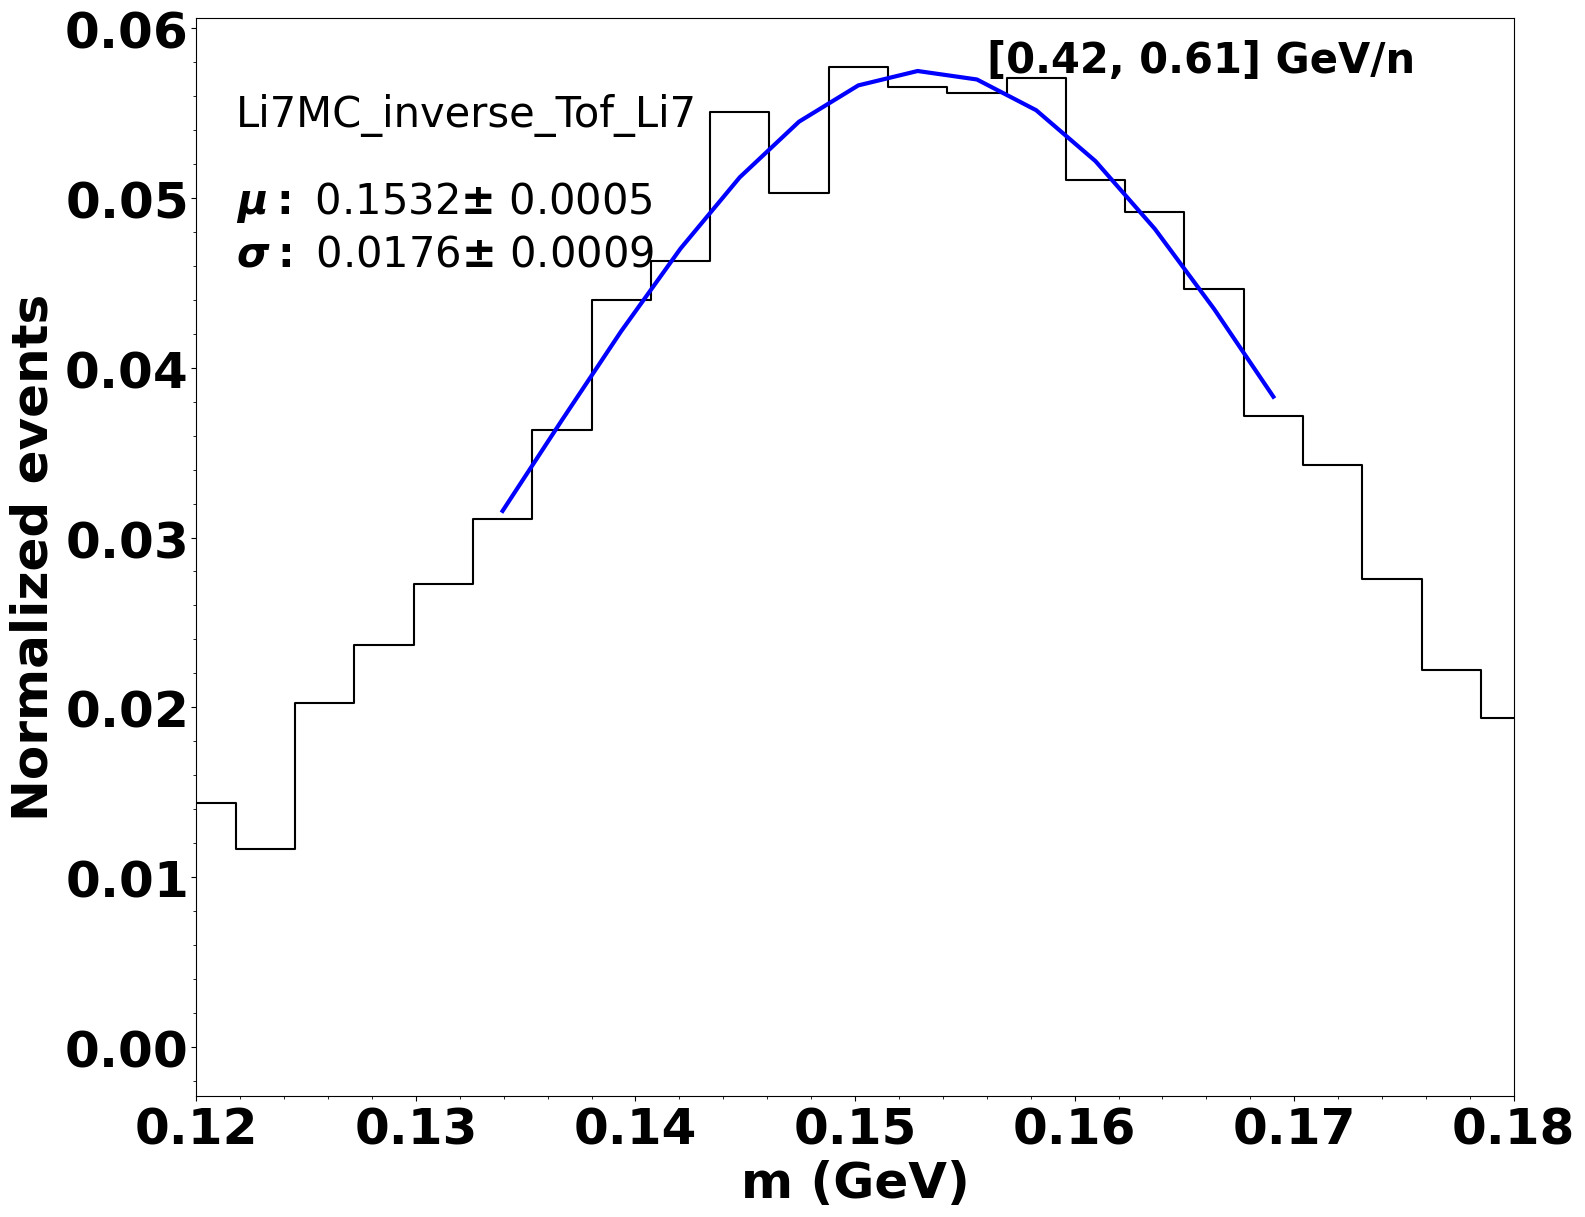

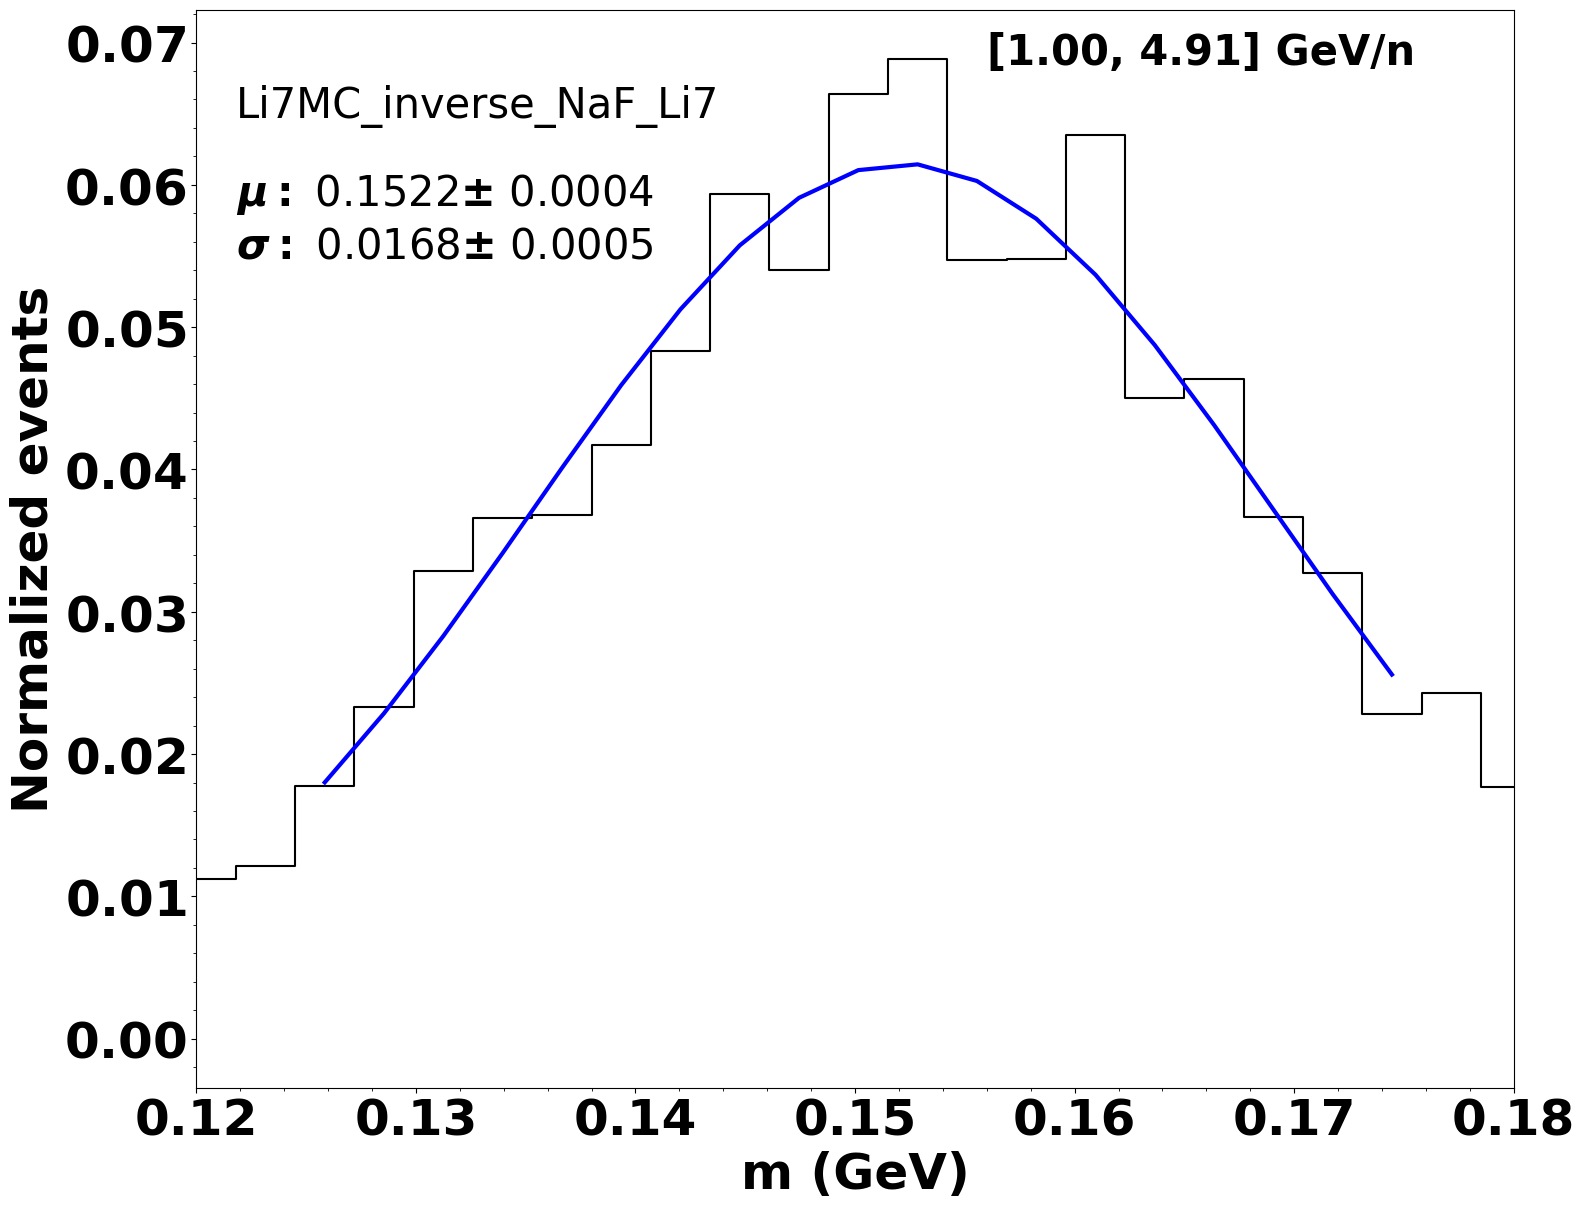

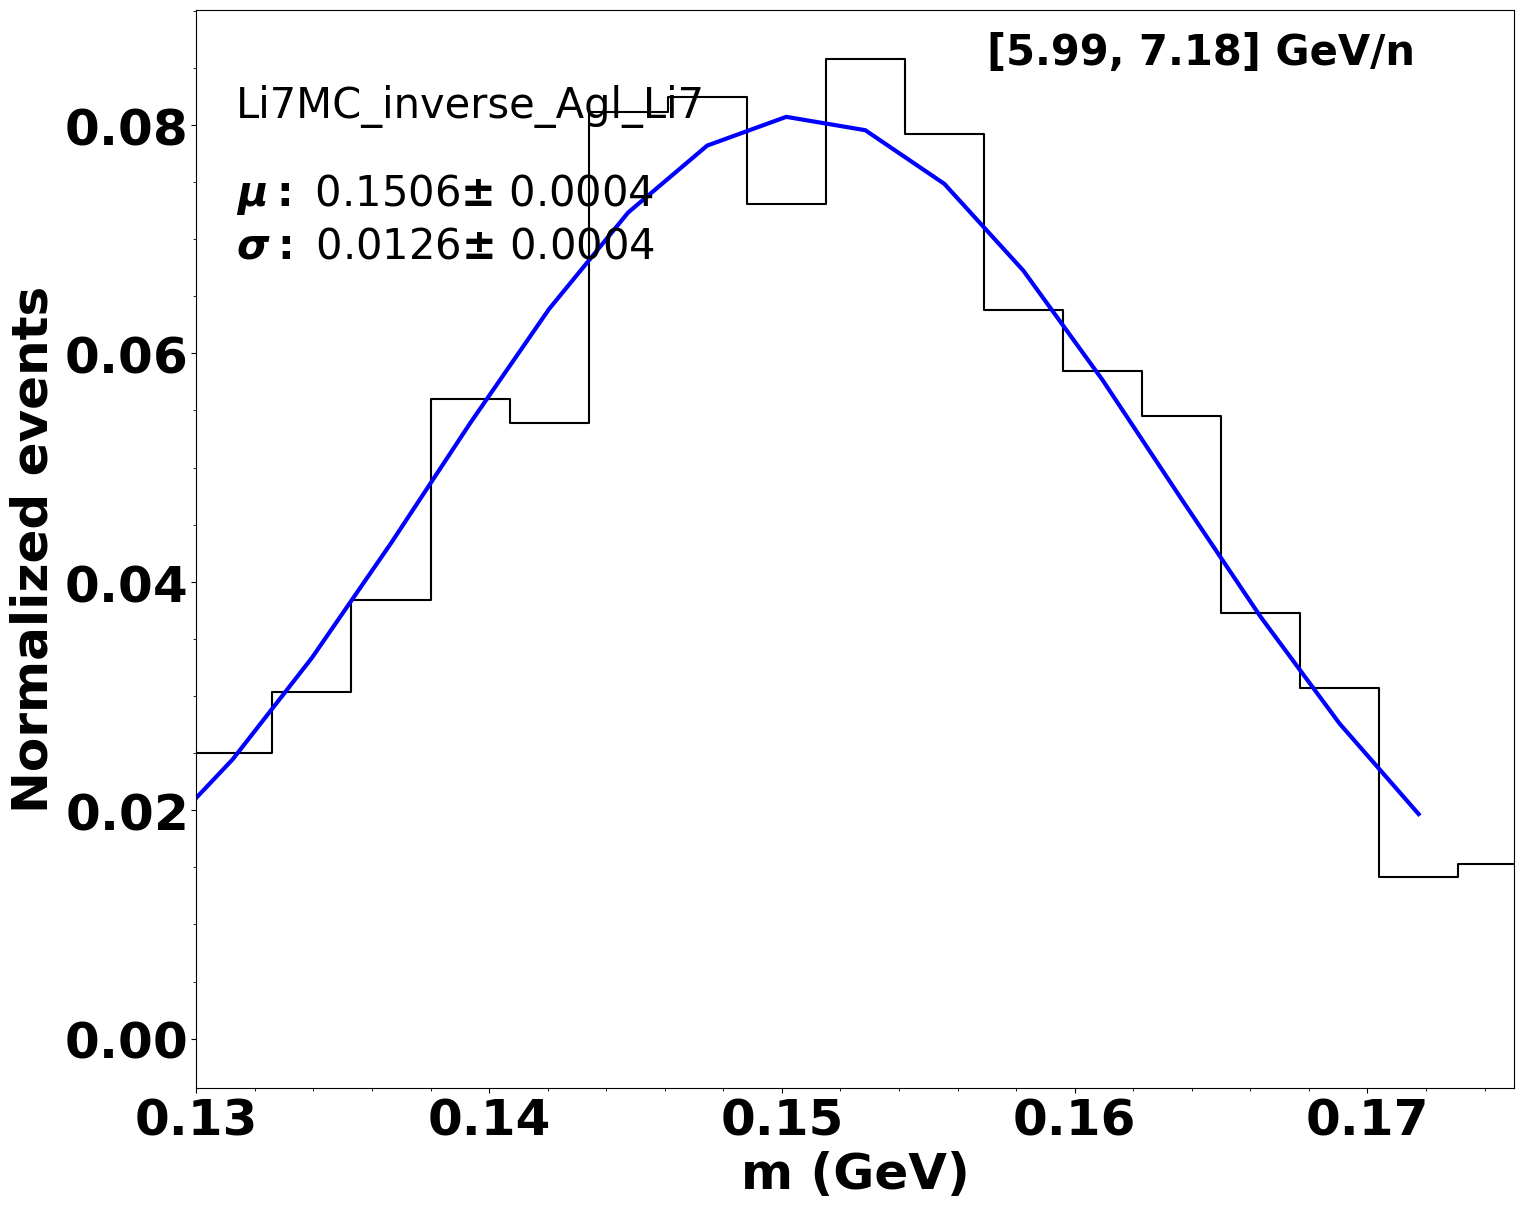

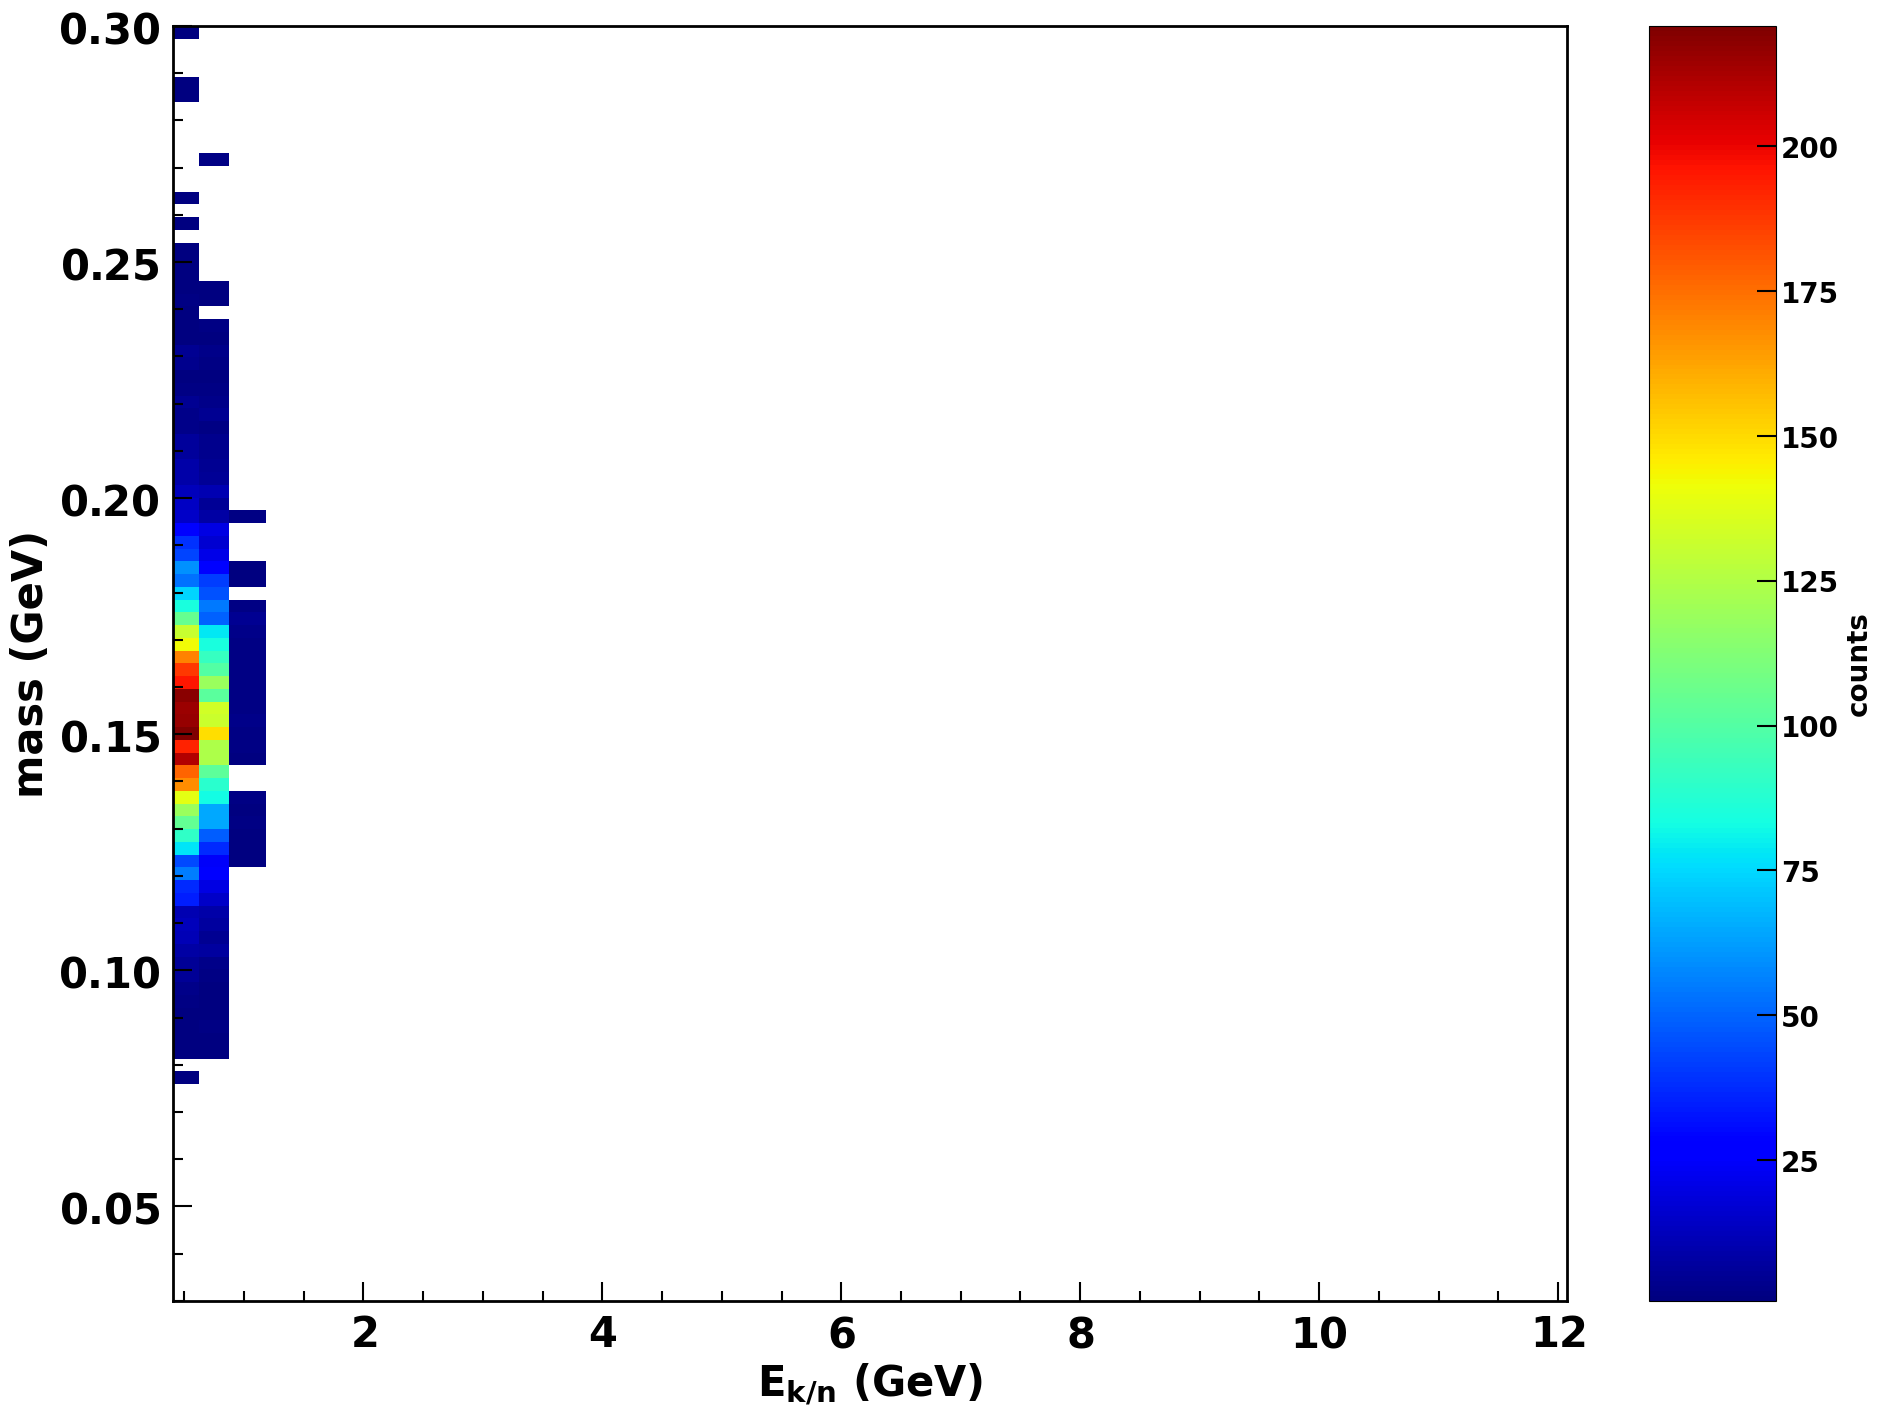

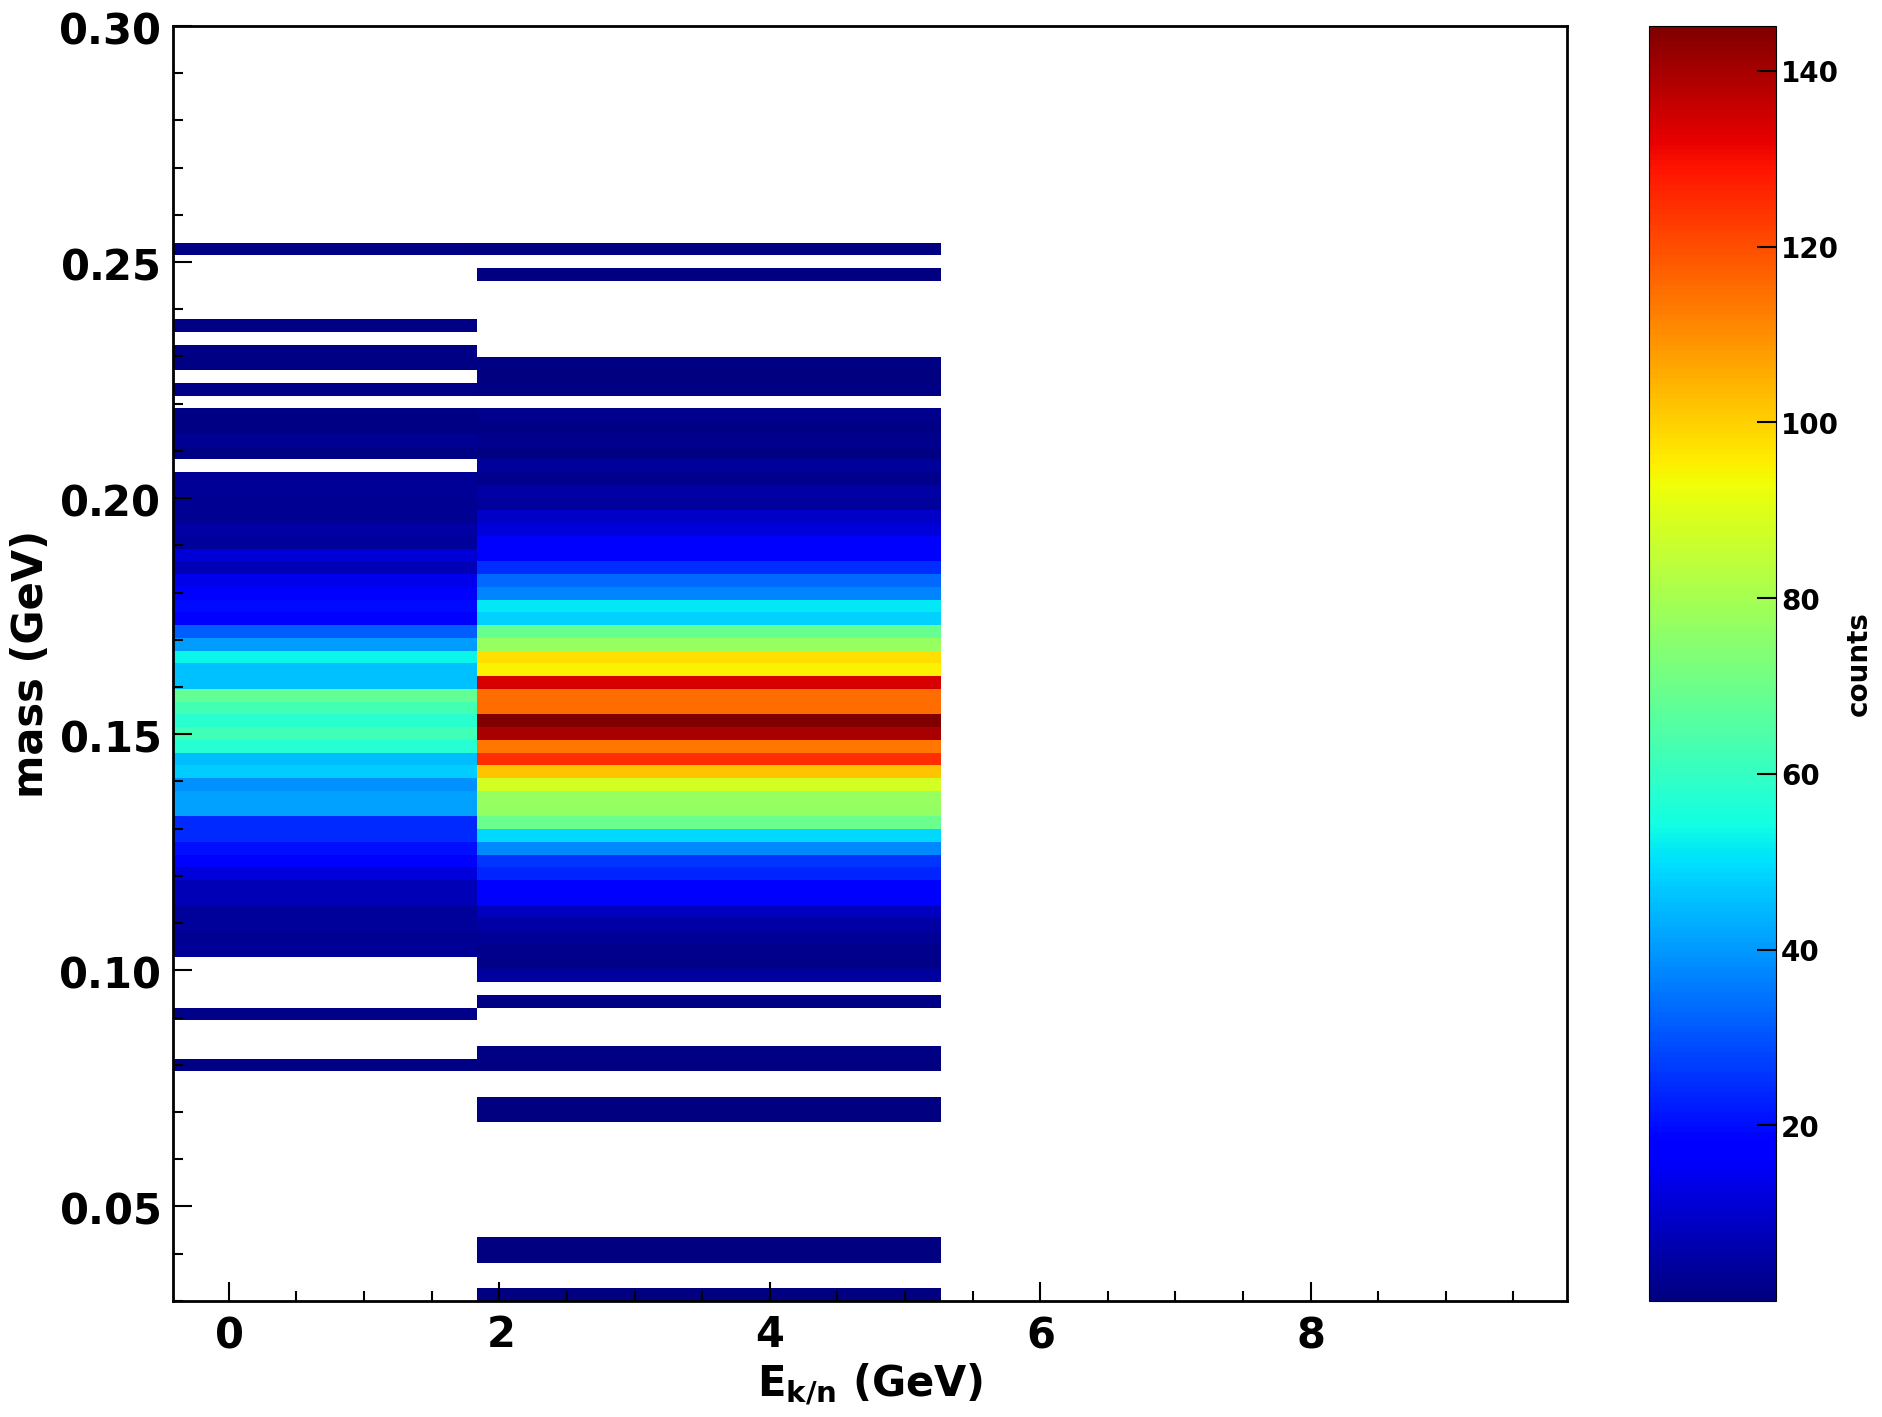

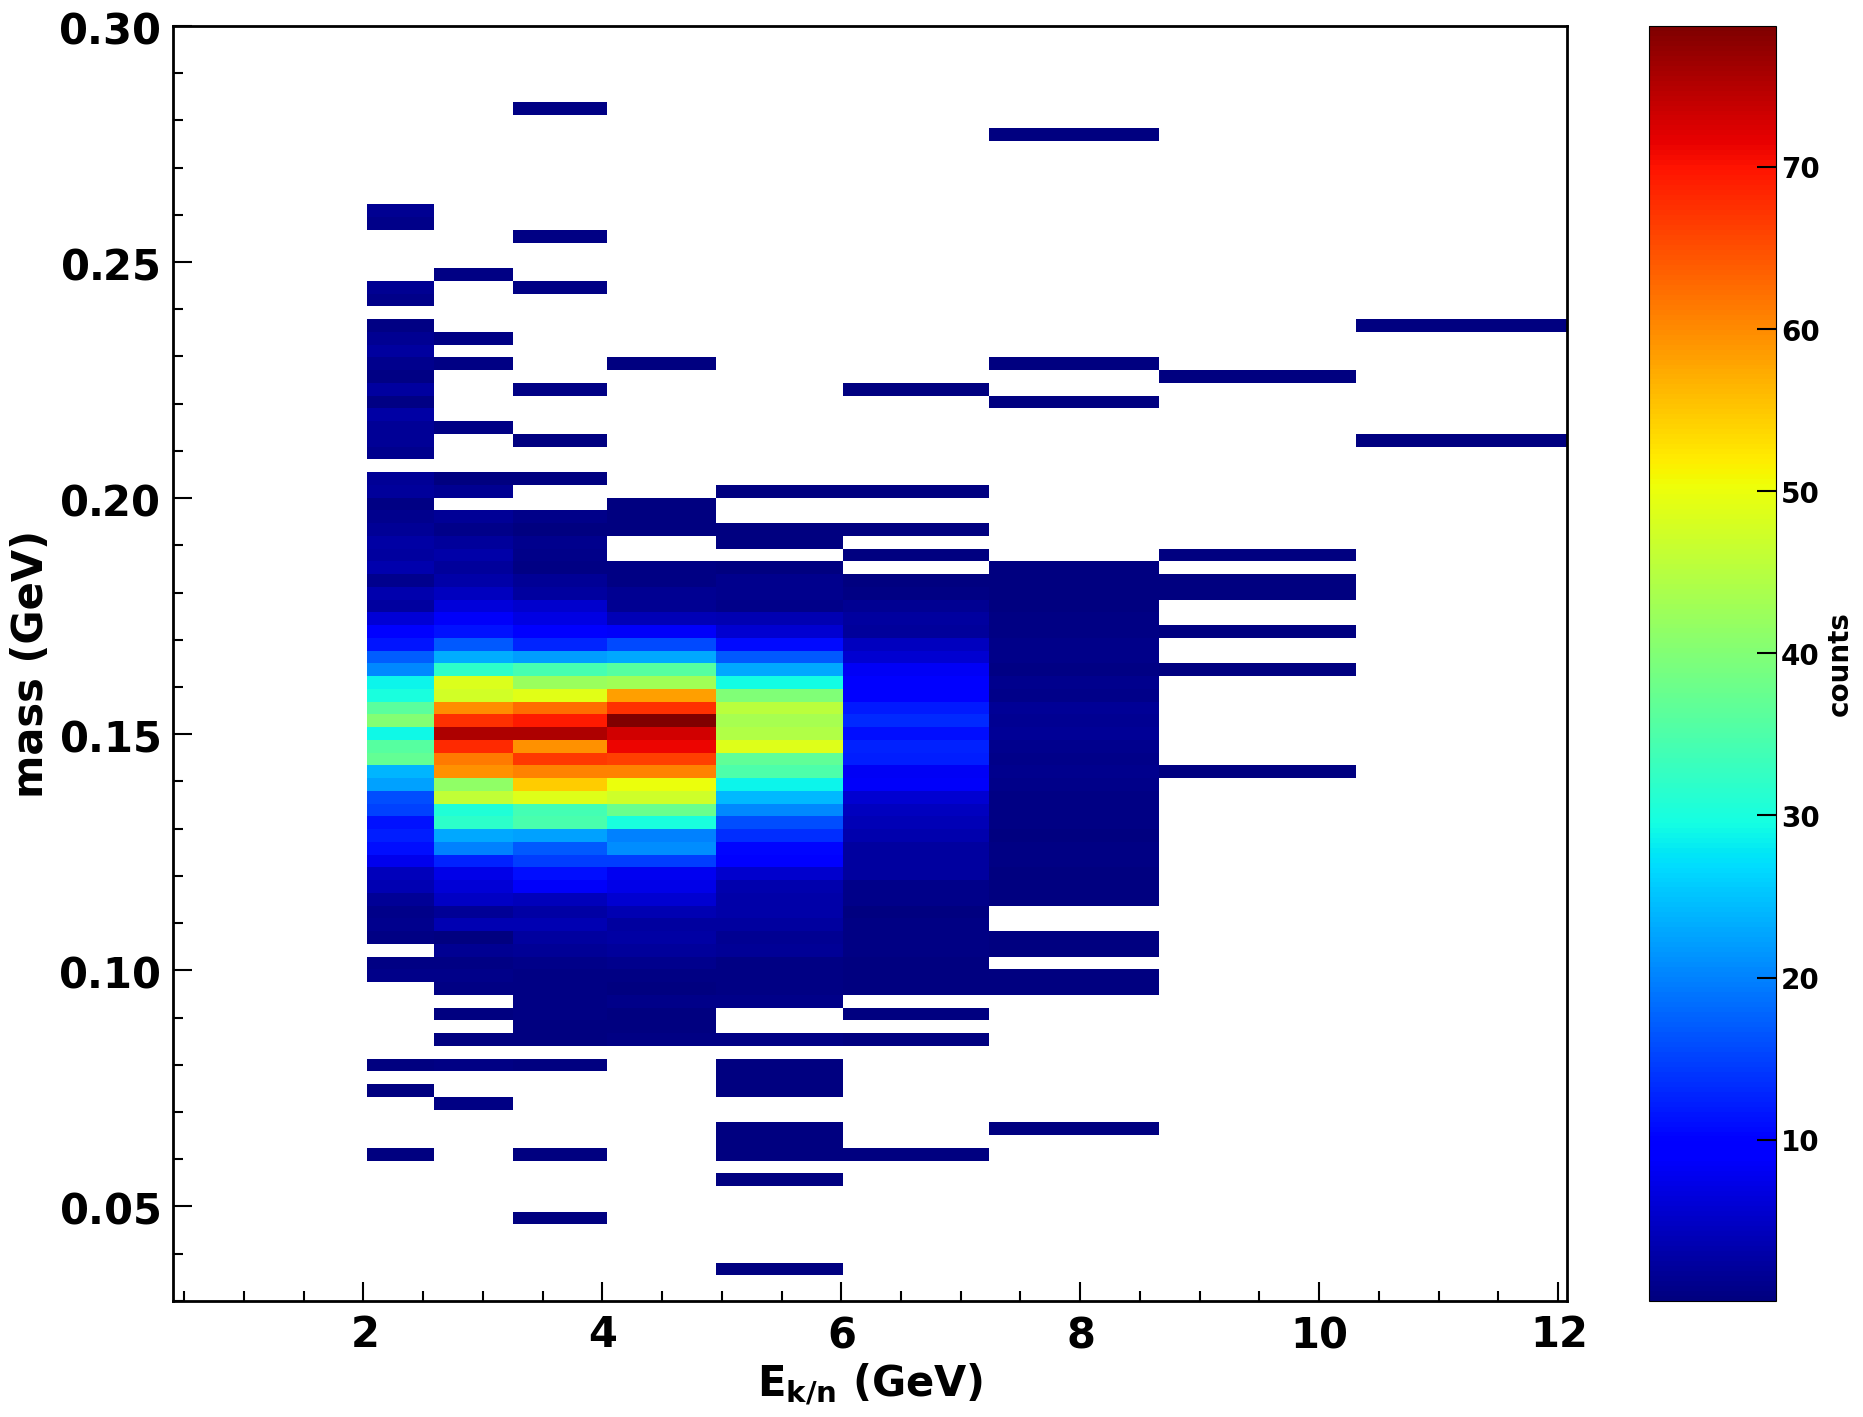

In [78]:
Nuclei = 'Li'
iso = 'Li7'
figName = 'Li7'

filename = {'Tof':f'/home/manbing/Documents/Data/data_{Nuclei}P8/rig_cutoff/Lihist_masscutoff_ToF.npz',
            'NaF':f'/home/manbing/Documents/Data/data_{Nuclei}P8/rig_cutoff/Lihist_masscutoff_NaF.npz',
            'Agl':f'/home/manbing/Documents/Data/data_{Nuclei}P8/rig_cutoff/Lihist_masscutoff_Agl.npz',
            }
            

detectors = ['Tof', 'NaF', 'Agl']
filename = {dec: filename[dec] for dec in detectors}
mtype = 'inv'
hist2dmass = {}

#xrange = {'inv': [0.11, 0.16], 'nor':[5.5, 8.0]}
#xrange = {'Tof': [0.09, 0.12], 'NaF': [0.09, 0.12], 'Agl': [0.09, 0.12]}
minbin = {'Tof': 1, 'NaF':2, 'Agl':11}
maxbin =  {'Tof':2,  'NaF':3, 'Agl':12}
sigmafactor = {'Tof':1.0,  'NaF':1.5, 'Agl':2.0}
guess0 = {'nor': dict(norm=20, mu=6.5, sigma=0.1), 'inv': dict(norm=1, mu=0.14, sigma=0.01)}
xrange = {'Tof': [0.12, 0.18], 'NaF': [0.12, 0.18], 'Agl': [0.13, 0.175]}
graph_mean_mcLi7 = {}
graph_sigma_mcLi7 = {}


for dec in detectors:
    decname = dec
    with np.load(filename[dec]) as histfile:      
        hist2dmass[dec] = WeightedHistogram.from_file(histfile, f"{iso}MC_{decname}_inversemasscutoff")  
        graph_mean_mcLi7[dec], graph_sigma_mcLi7[dec] = get_musigma_gausfit(hist2dmass[dec], minbin[dec], maxbin[dec], guess0[mtype], xrange[dec], FigName=f'Li7MC_inverse_{dec}_{figName}', plotfile=plotfile, sigmafactor=sigmafactor[dec])
        print(graph_mean_mcLi7[dec])

for dec in detectors:  
    fig = plt.figure(figsize=(20, 15)) 
    plot = fig.subplots(1, 1)    
    set_plot_style(plot)
    plot2dhist(fig, plot, xbinning=hist2dmass[dec].binnings[0].edges[1:-1], 
               ybinning=hist2dmass[dec].binnings[1].edges[1:-1],                                                                                                                        
               counts=hist2dmass[dec].values[1:-1, 1:-1],                                                                                                                               
               xlabel=r'$\mathrm{E_{k/n} \ (GeV)}$', ylabel='mass (GeV)', zlabel='counts', zmin=None, zmax=None,                                                                                                                        
               setlogx=False, setlogy=False, setscilabelx=True, setscilabely=True,  setlogz=False)    
    savefig_tofile(fig, plotfile, f"hist2d_Li7Cutoff_MC_inversemass_{dec}_{figName}", show=True)    




xvalues			yvalues			yerrs
0.5144			0.15411955925642762			0.000586914204815477


xvalues			yvalues			yerrs
2.9573			0.15160809857690605			0.00029840694671293496


xvalues			yvalues			yerrs
6.58395			0.15050731599369063			0.00052447685865014



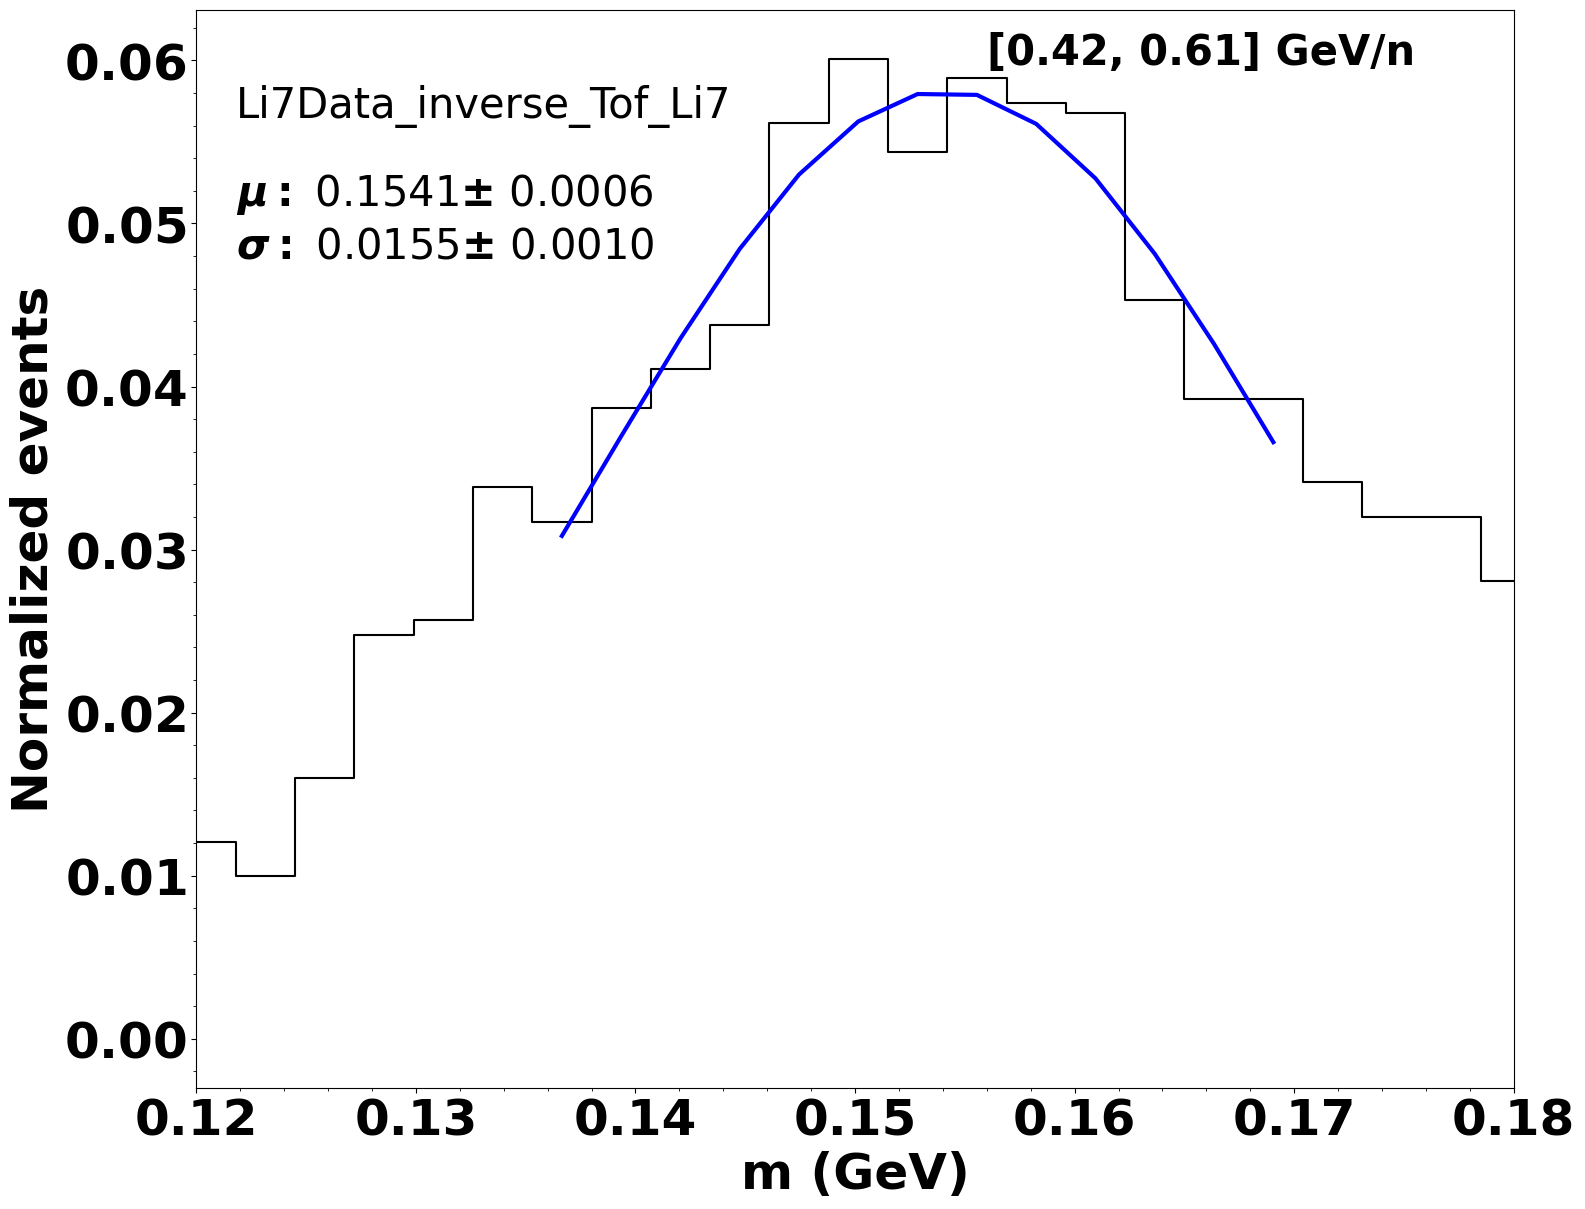

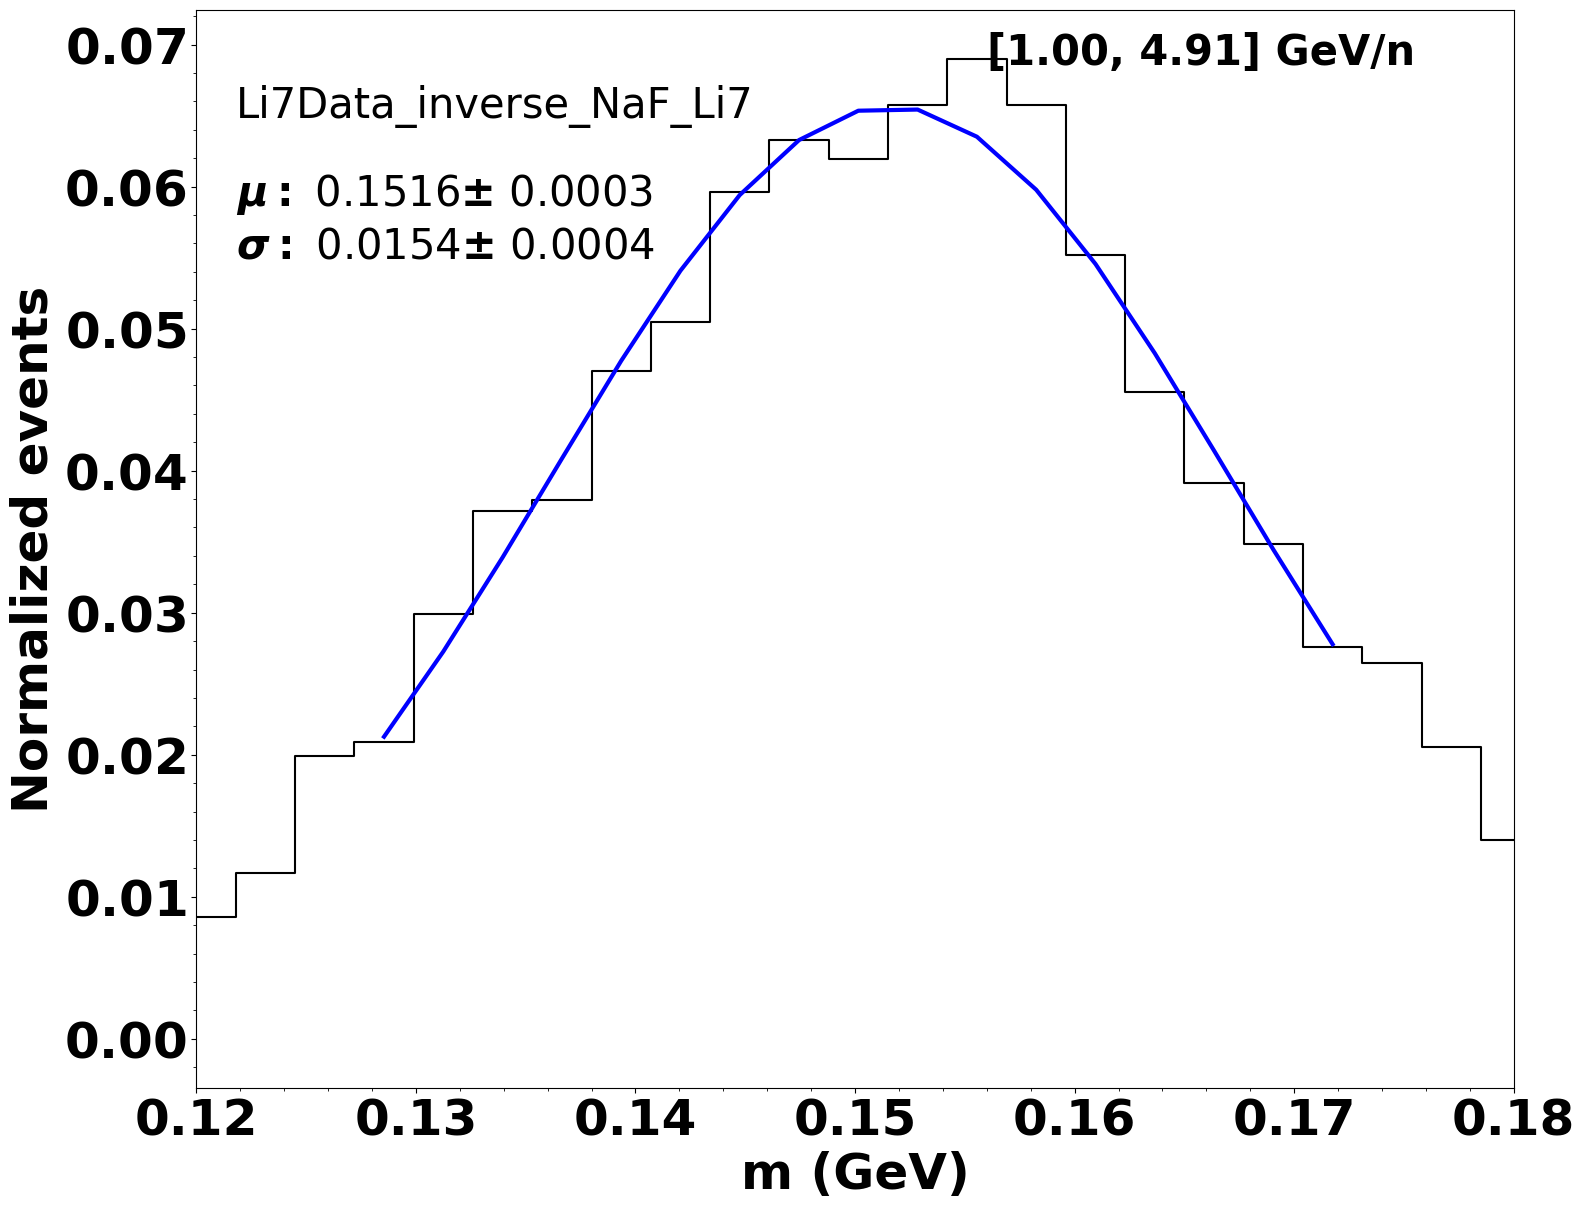

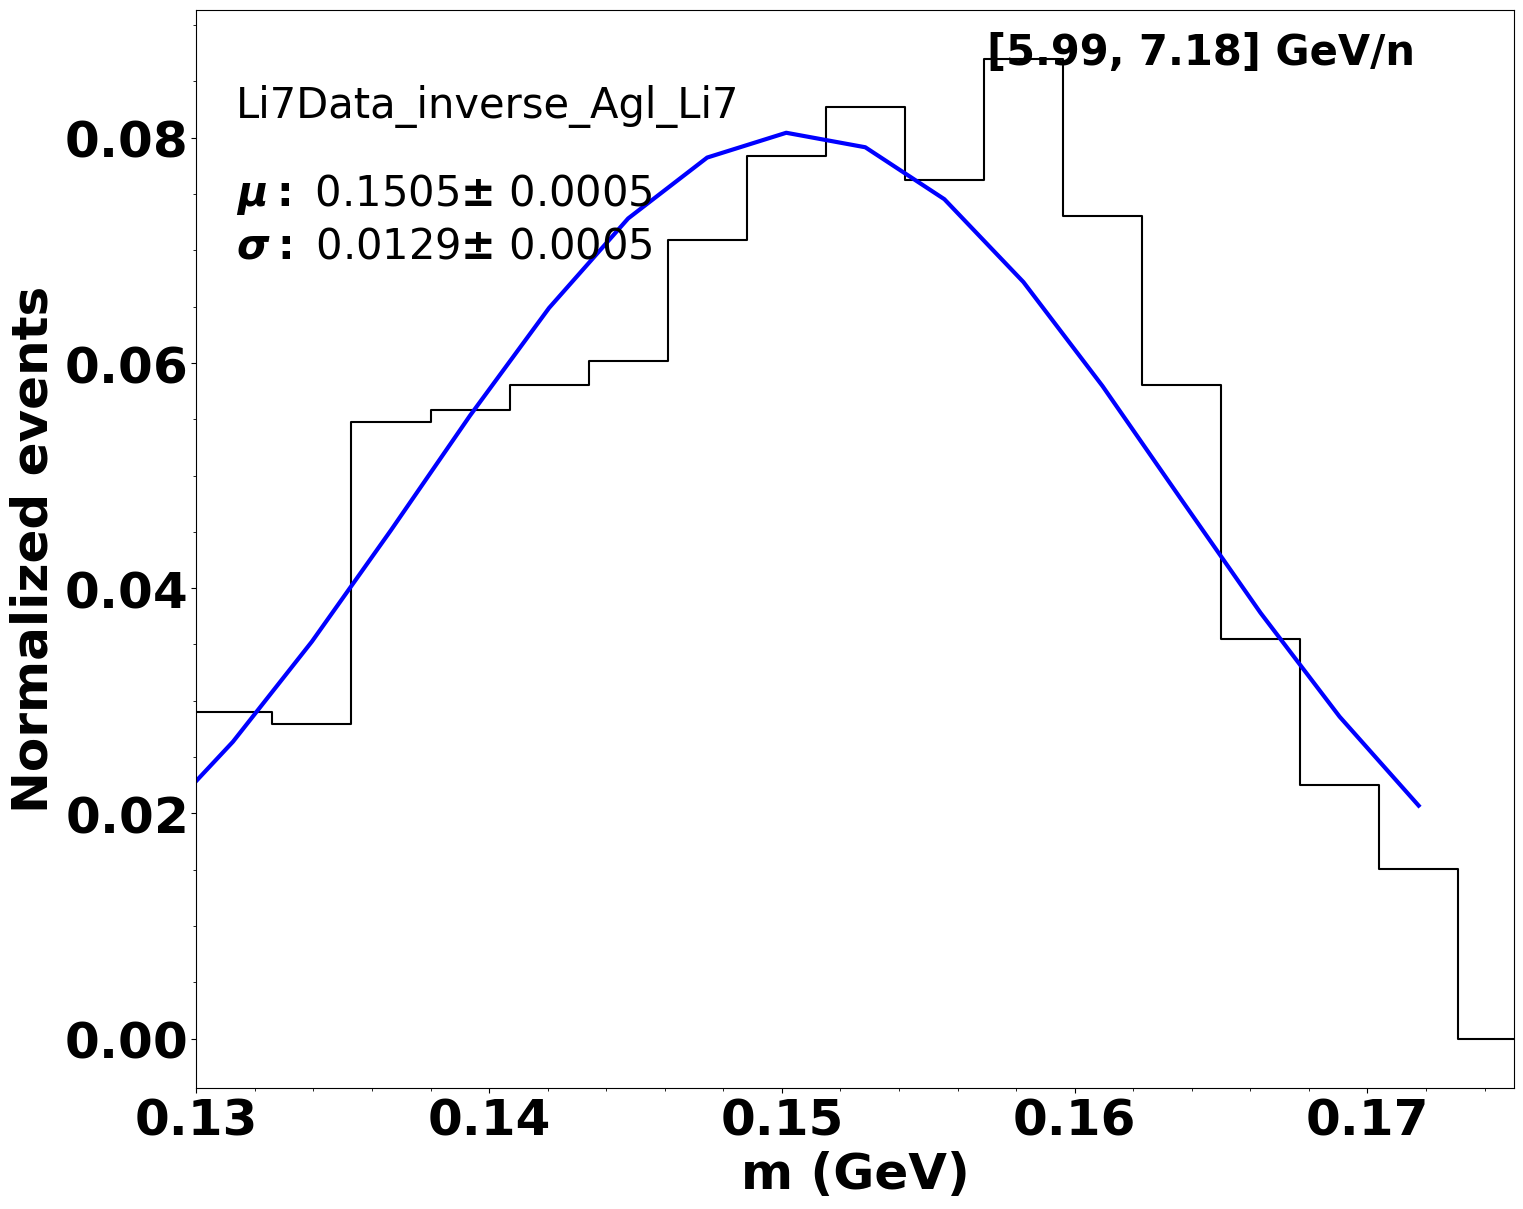

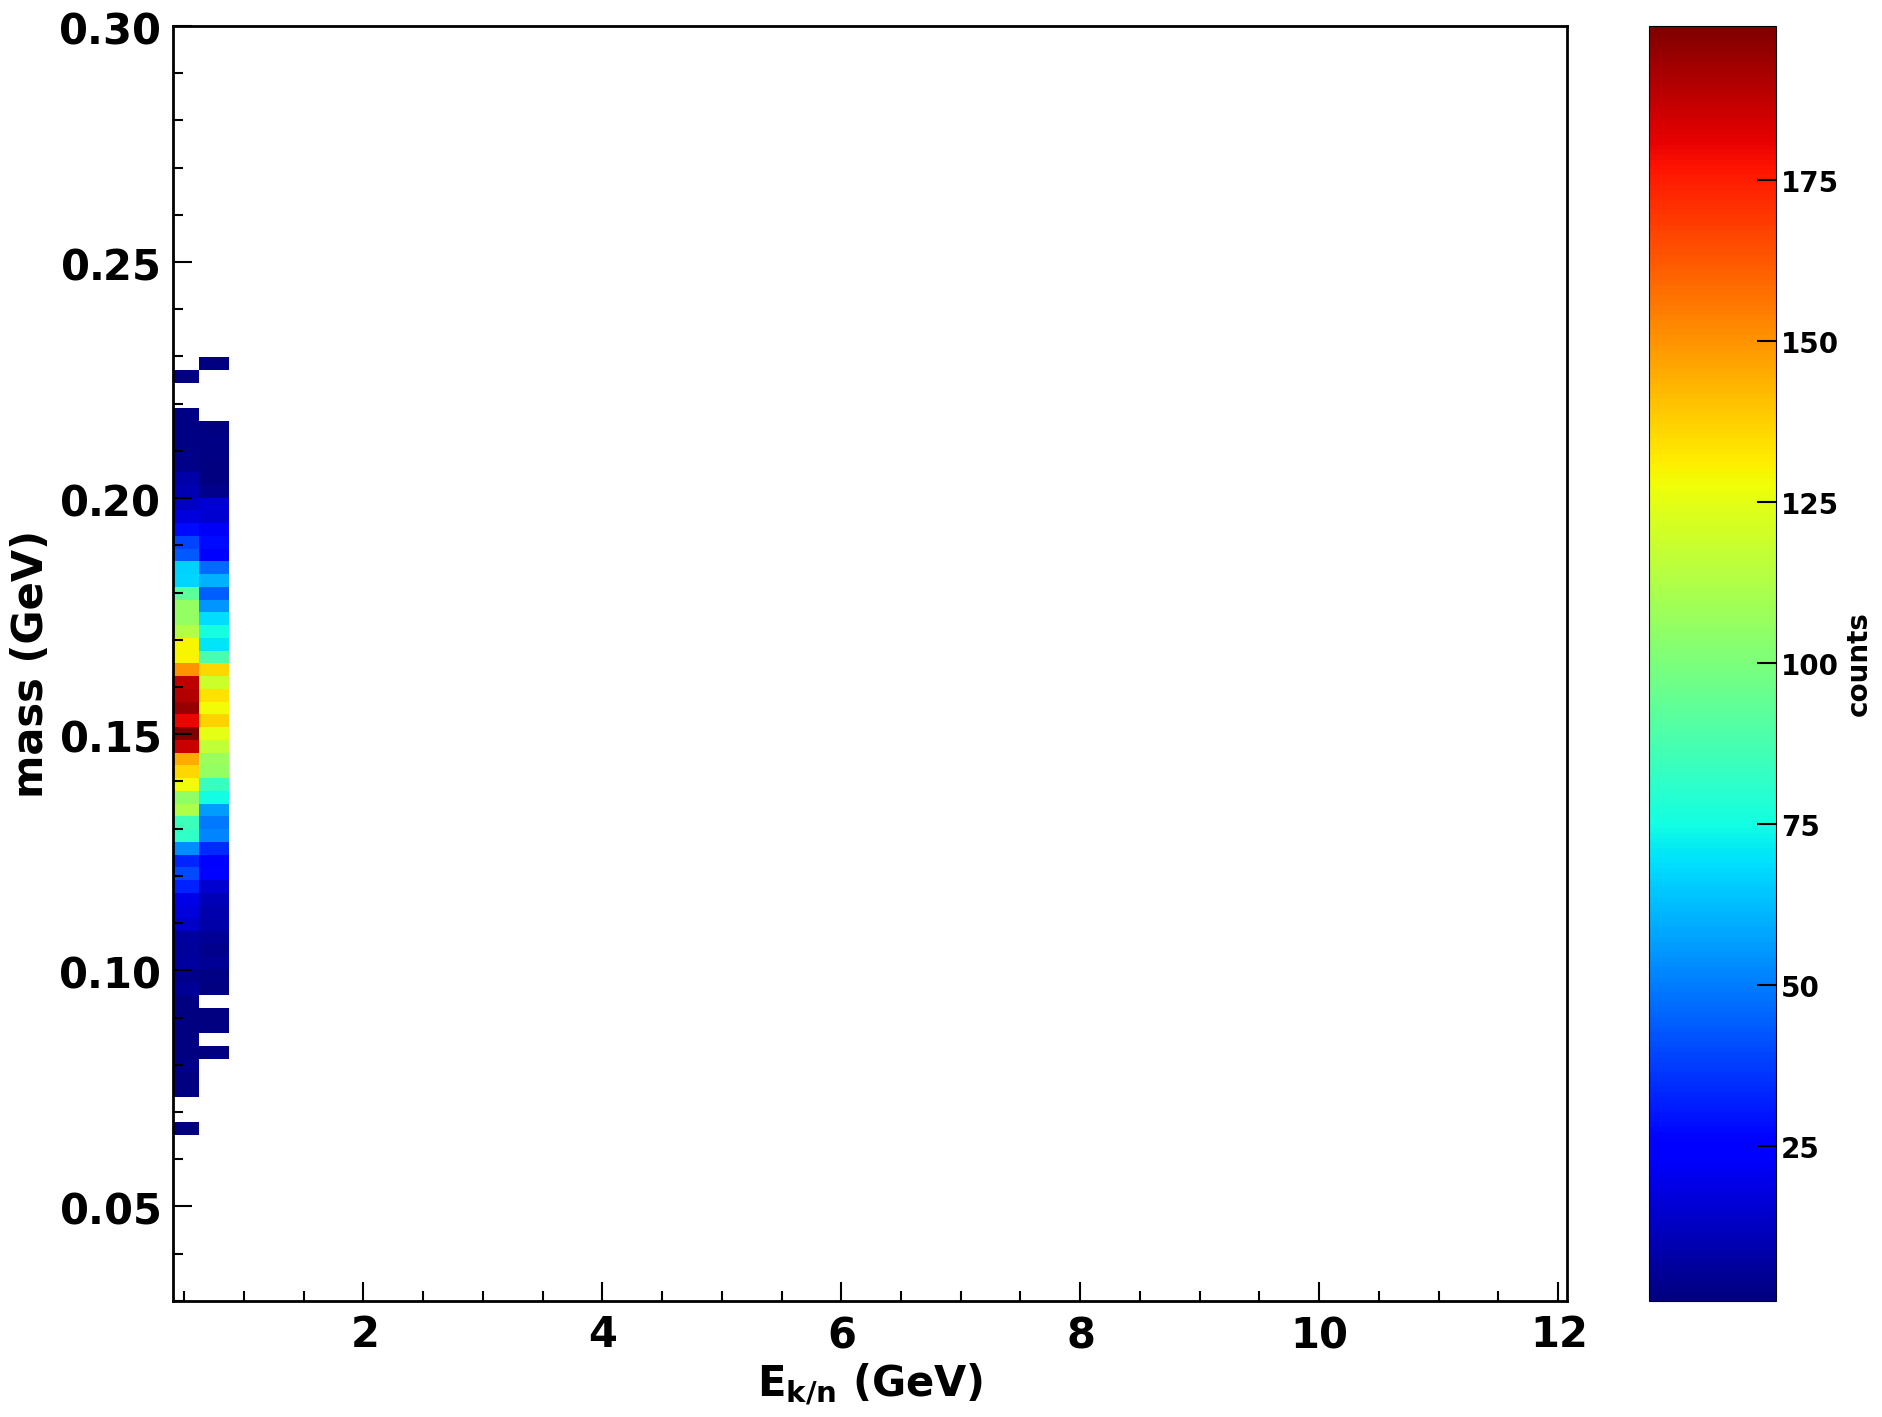

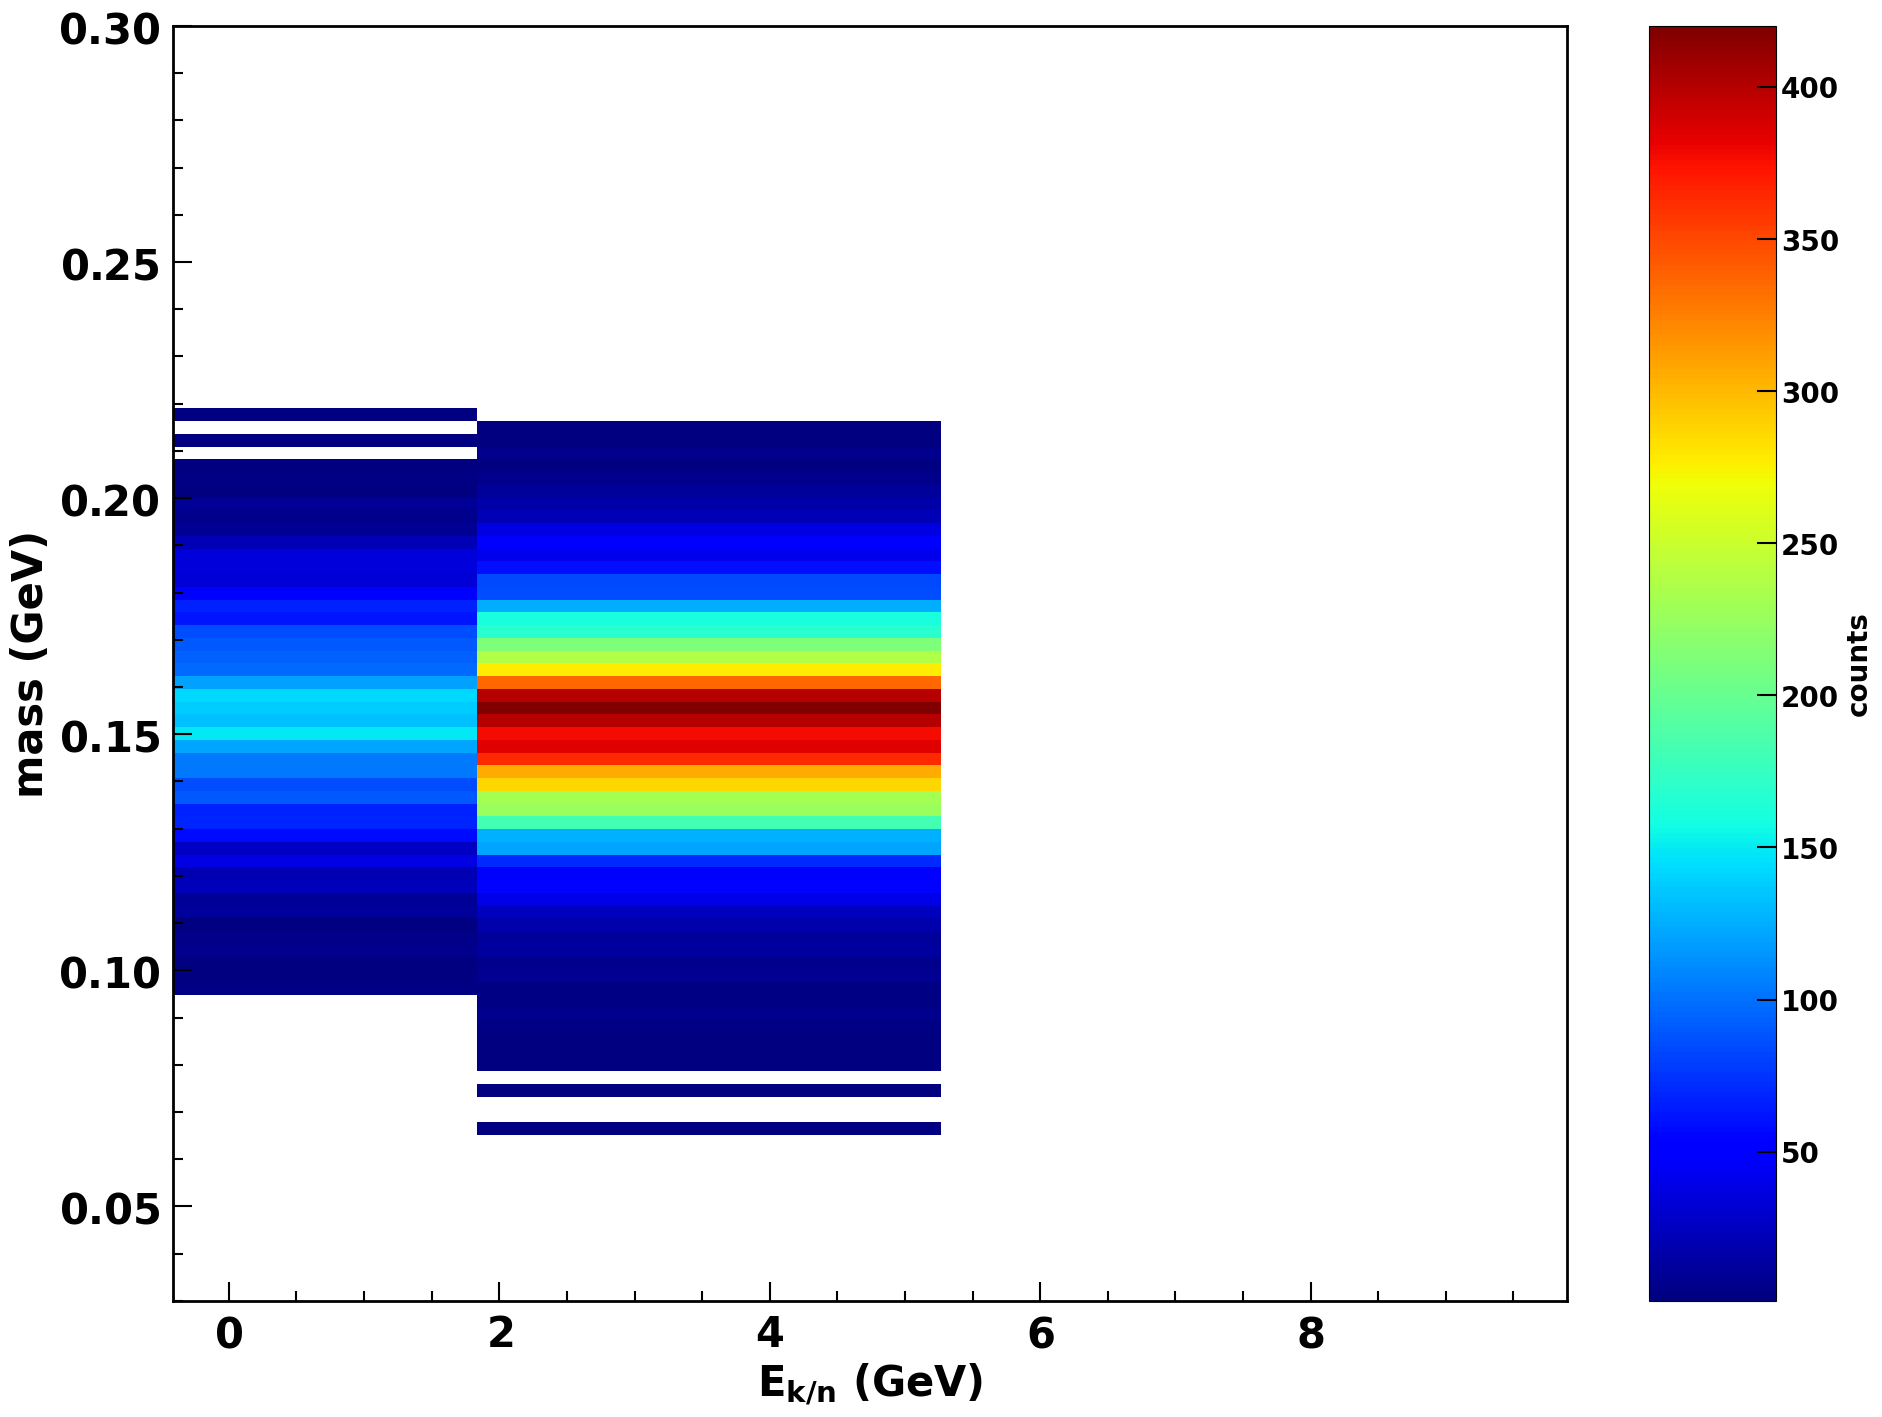

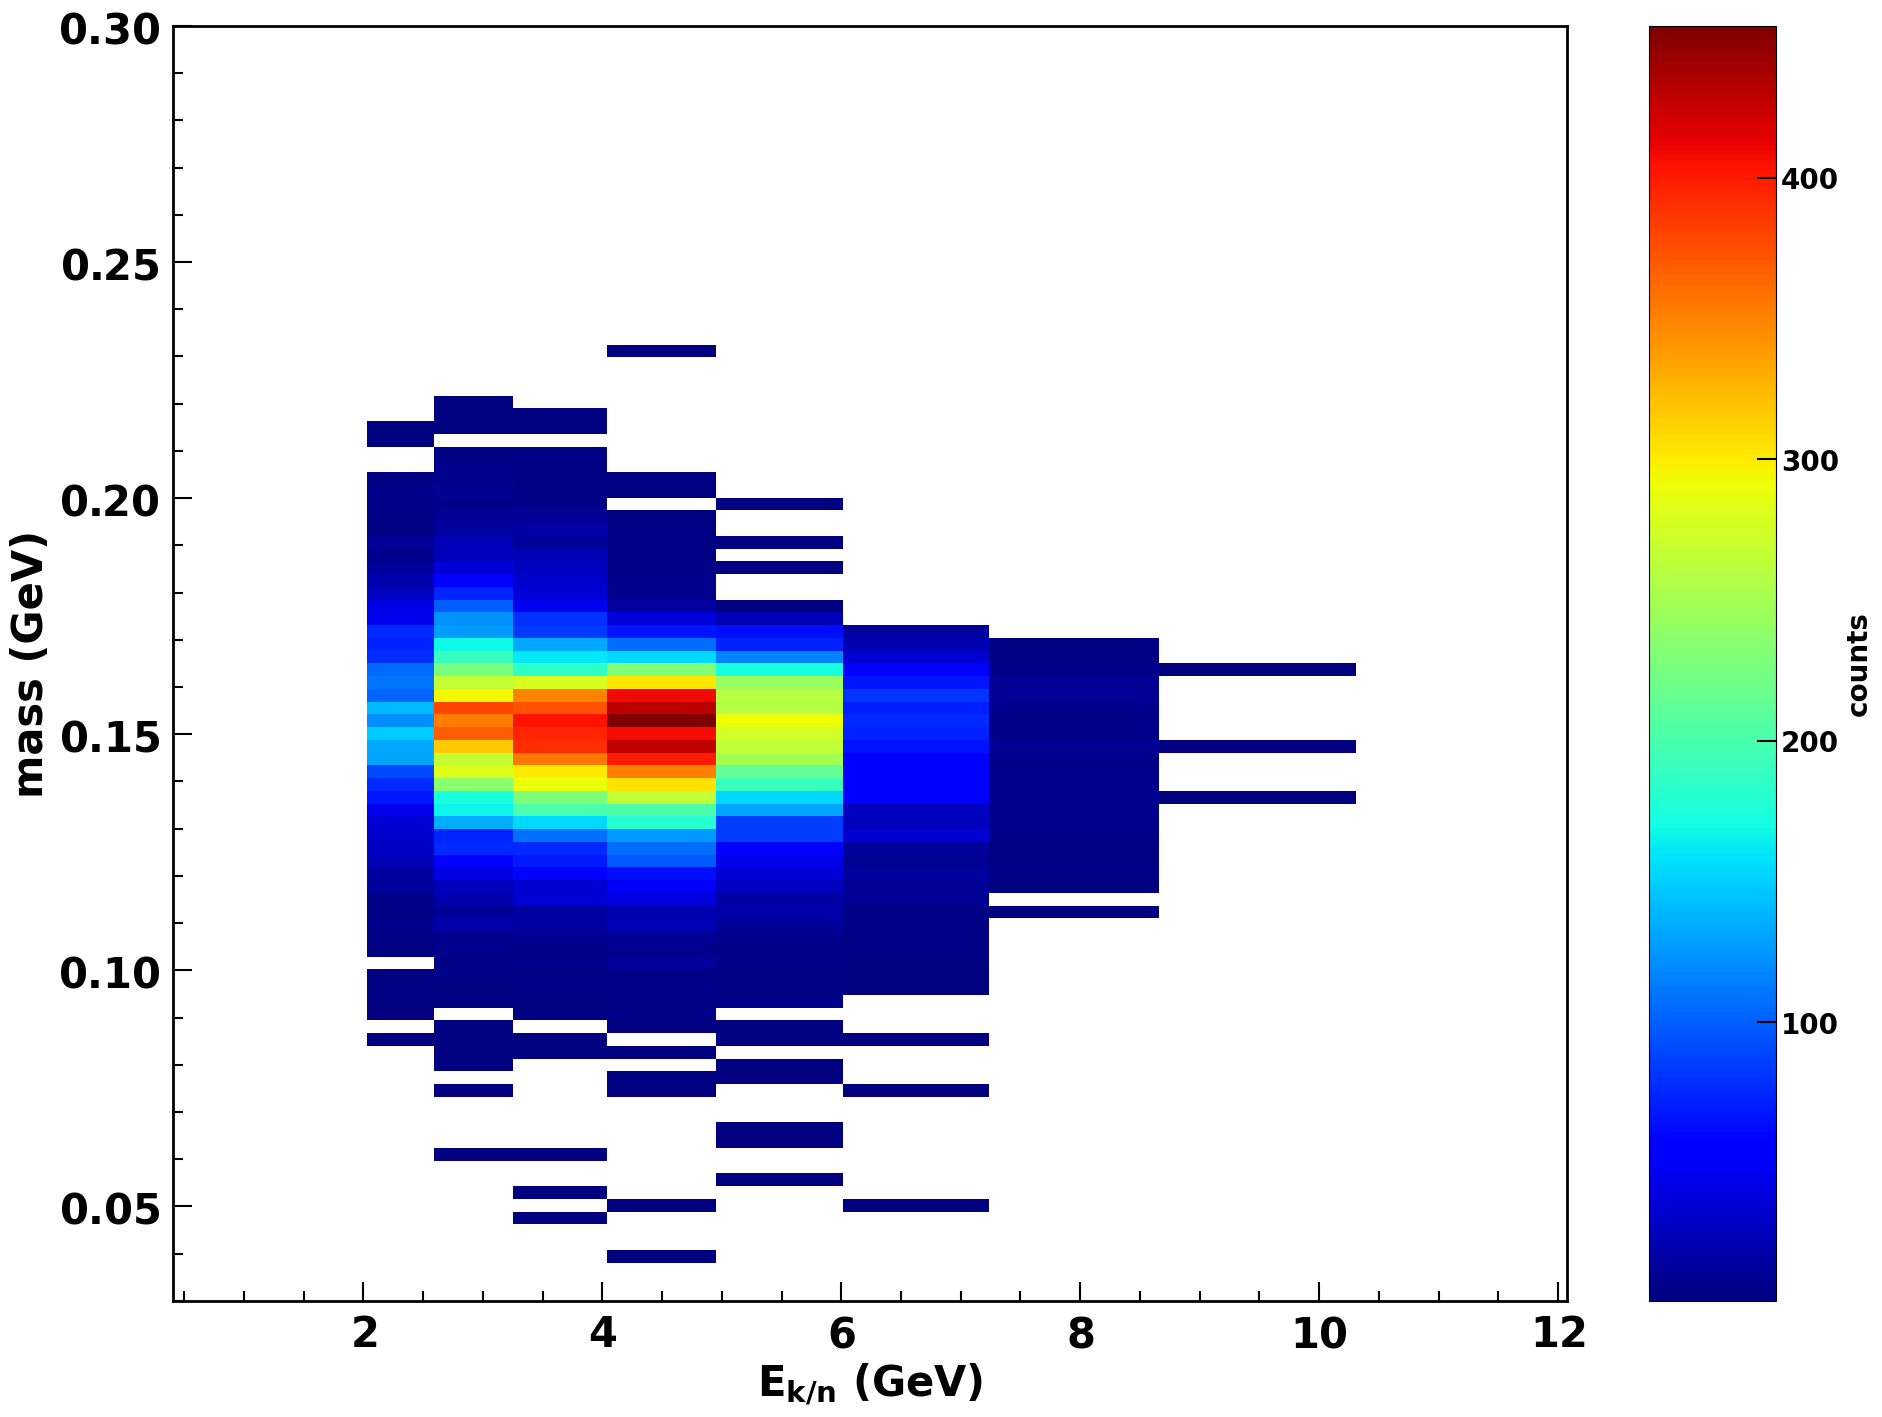

In [79]:
hist2dmass_iss = {}
graph_mean_issLi7 = {}
graph_sigma_issLi7 = {}

for dec in detectors:
    decname = dec
    with np.load(filename[dec]) as histfile:
        hist2dmass_iss[dec] = Histogram.from_file(histfile, f"{iso}ISS_{decname}_inversemasscutoff")  
        graph_mean_issLi7[dec], graph_sigma_issLi7[dec] = get_musigma_gausfit(hist2dmass_iss[dec], minbin[dec], maxbin[dec], guess0[mtype], xrange[dec], FigName=f'Li7Data_inverse_{dec}_{figName}', plotfile=plotfile, sigmafactor=sigmafactor[dec])
        print(graph_mean_issLi7[dec])
        

for dec in detectors:
    fig = plt.figure(figsize=(20, 15)) 
    plot = fig.subplots(1, 1)    
    set_plot_style(plot)
    plot2dhist(fig, plot, xbinning=hist2dmass_iss[dec].binnings[0].edges[1:-1], 
               ybinning=hist2dmass_iss[dec].binnings[1].edges[1:-1],                                                                                                                        
               counts=hist2dmass_iss[dec].values[1:-1, 1:-1],                                                                                                                               
               xlabel=r'$\mathrm{E_{k/n} \ (GeV)}$', ylabel='mass (GeV)', zlabel='counts', zmin=None, zmax=None,                                                                                                                        
               setlogx=False, setlogy=False, setscilabelx=True, setscilabely=True,  setlogz=False)   

    savefig_tofile(fig, plotfile, f"hist2d_Li7Cutoff_ISS_inverse_{dec}_{figName}", show=True)  

Tof

xvalues			yvalues			yerrs
0.5144			0.15320118135497302			0.000542917566187676


xvalues			yvalues			yerrs
0.5144			0.15411955925642762			0.000586914204815477


xvalues			yvalues			yerrs
0.5144			0.005994587596075407			0.005233189439839377

NaF

xvalues			yvalues			yerrs
2.9573			0.15219227876930794			0.00040534963792285327


xvalues			yvalues			yerrs
2.9573			0.15160809857690605			0.00029840694671293496


xvalues			yvalues			yerrs
2.9573			-0.0038384351500997393			0.0032990616262131883

Agl

xvalues			yvalues			yerrs
6.58395			0.15064828739281005			0.0004237856890819746


xvalues			yvalues			yerrs
6.58395			0.15050731599369063			0.00052447685865014


xvalues			yvalues			yerrs
6.58395			-0.0009357650296537567			0.004474284303522182



/home/manbing/Documents/lithiumanalysis/scripts/tools/graphs.py:284: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  result = plot.errorbar(values_x, values_y, (errors_y_low, errors_y_high), fmt='.', color=color, label=label, **kwargs)


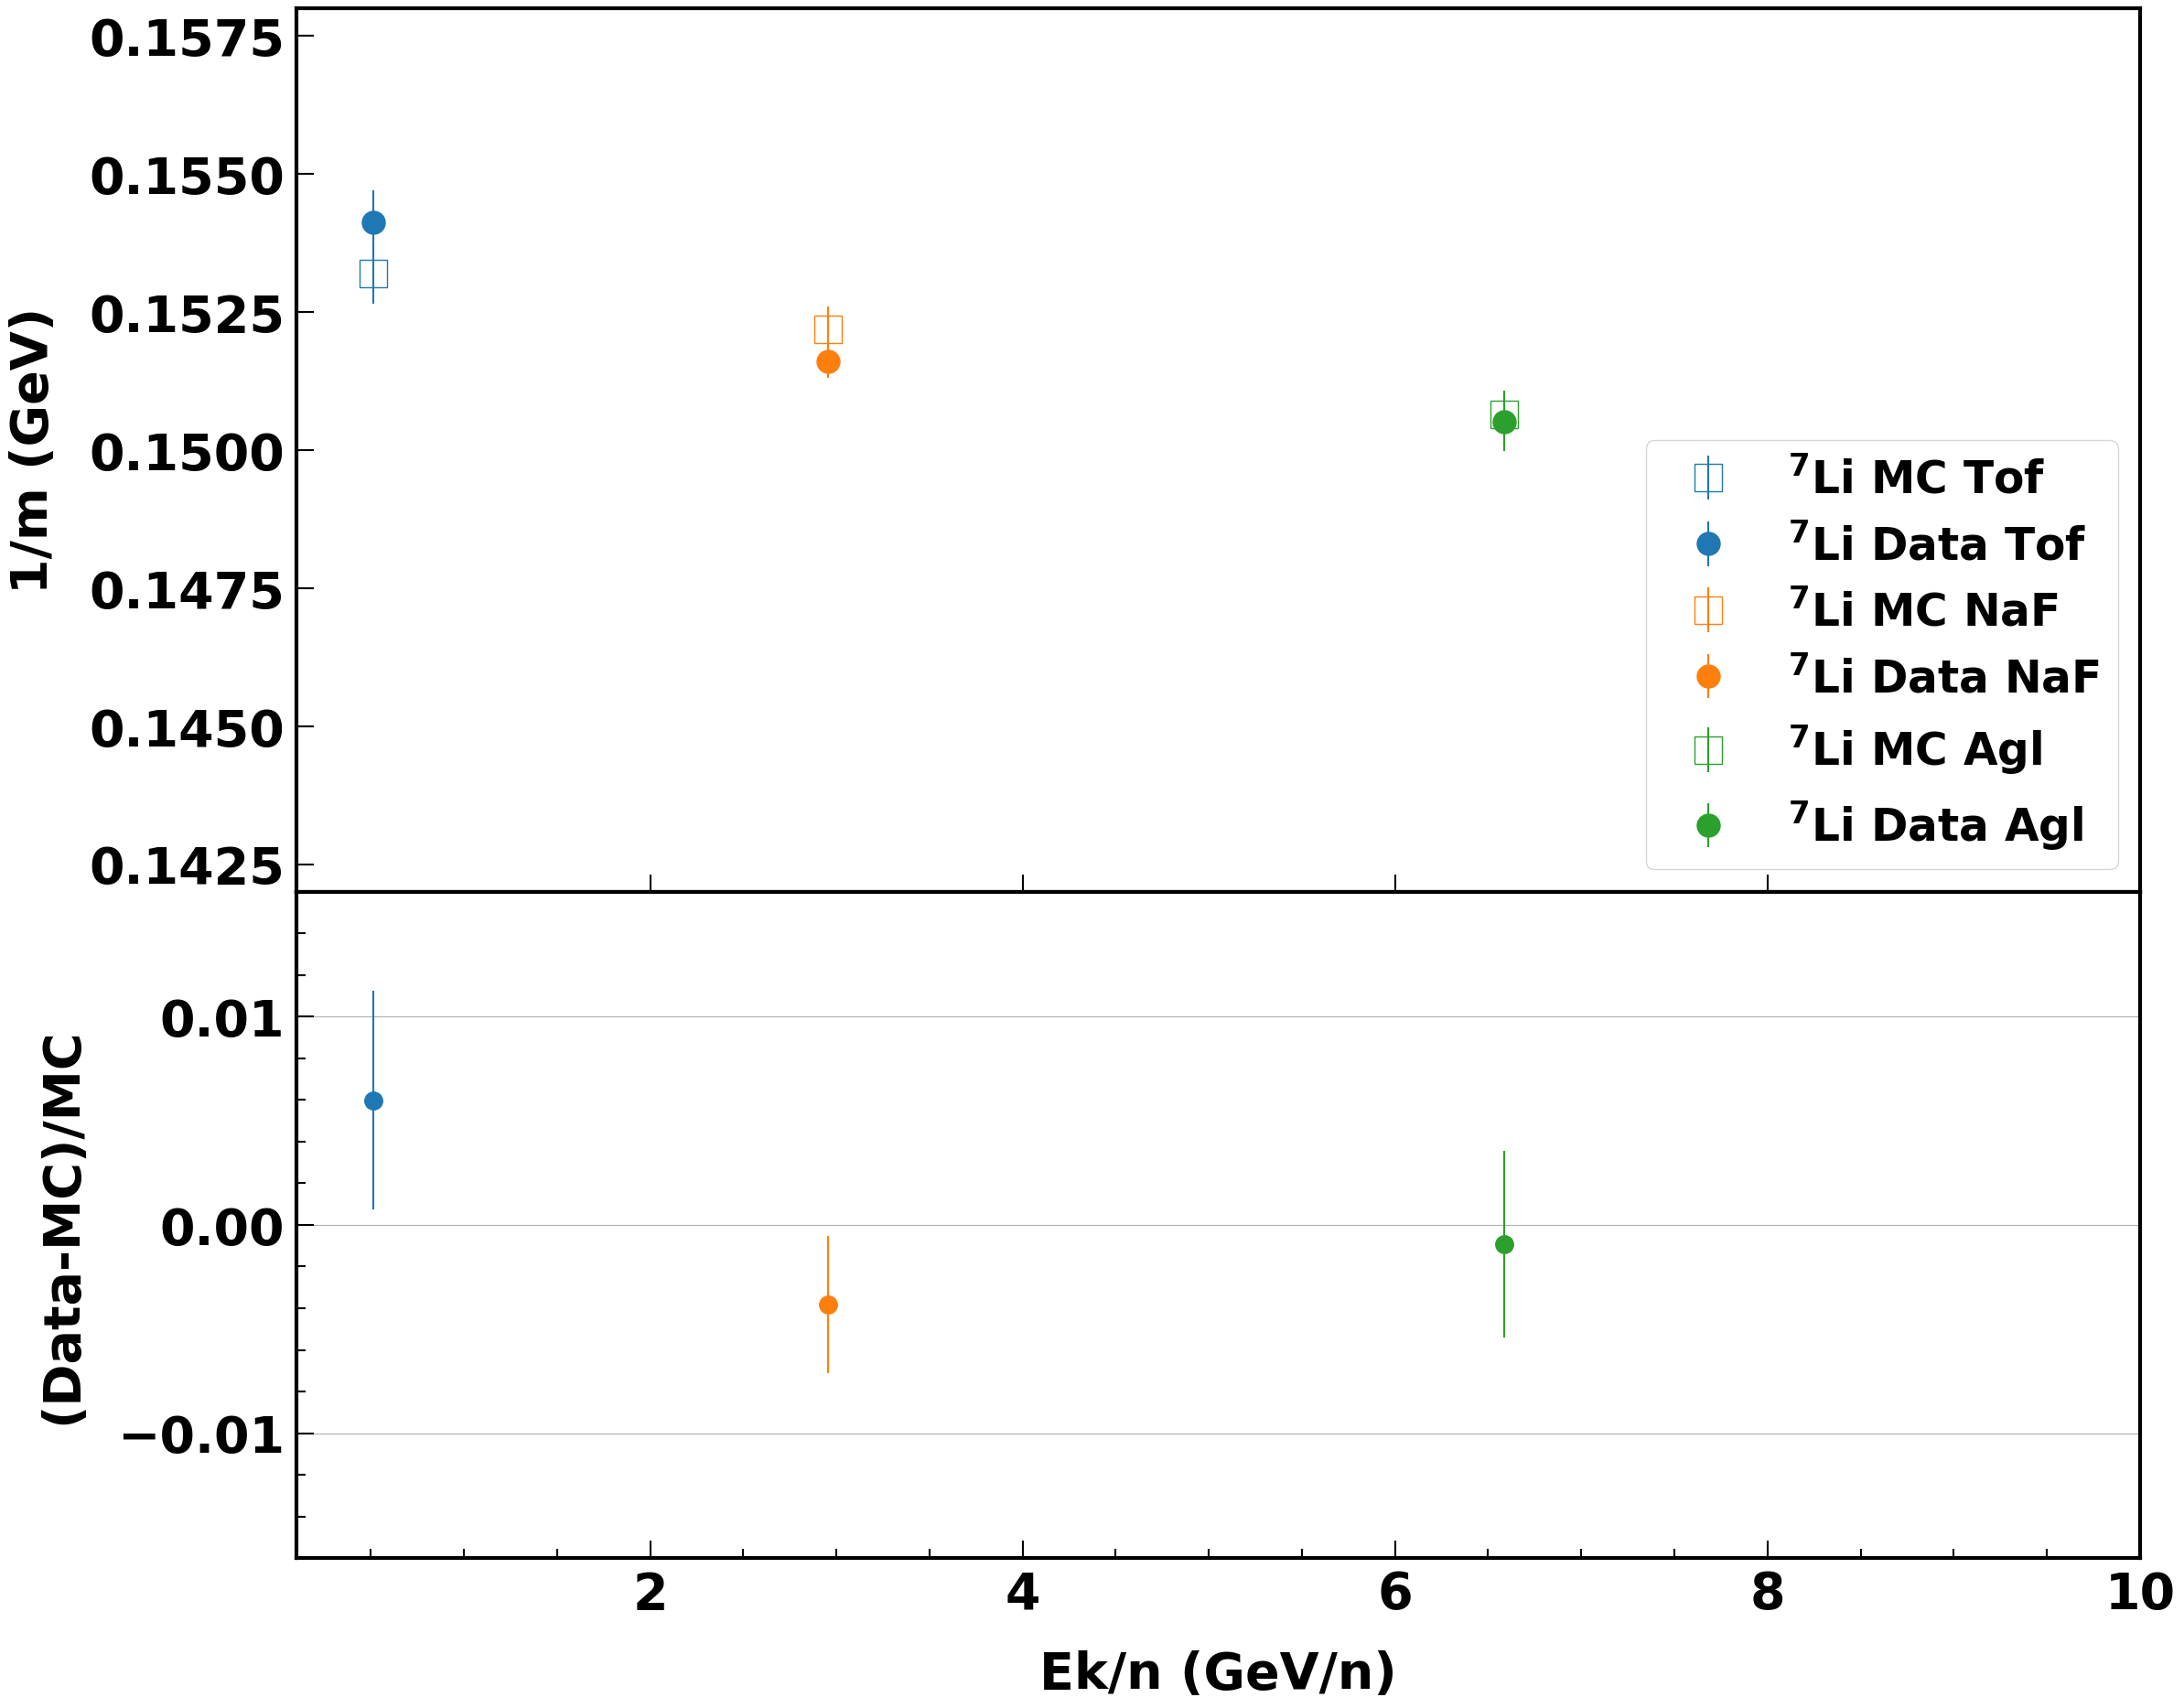

In [80]:
figsize = (26, 22)
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios':[0.57, 0.43]}, figsize=figsize) 


graph_mean_issLi7['Agl'] = slice_graph_by_value(graph_mean_issLi7['Agl'], [4, 8])
graph_mean_mcLi7['Agl'] = slice_graph_by_value(graph_mean_mcLi7['Agl'], [4, 8])

graph_ratio = {}
dic_save ={}
for dec in detectors:
    decname = dec
    graph_ratio[dec] = graph_mean_issLi7[dec]/graph_mean_mcLi7[dec]
    graph_ratio[dec].yvalues -= 1.0
    print(dec)
    print(graph_mean_mcLi7[dec])
    print(graph_mean_issLi7[dec])
    print(graph_ratio[dec])
    graph_ratio[dec].add_to_file(dic_save, f'graph_cutoff_mean_{dec}')

    
#if save
#np.savez(os.path.join('/path', 'graph_cutoff_mean.npz'), **dic_save)

for dec in detectors:
    decname = dec
    plot_graph(fig, ax1, graph_mean_mcLi7[dec], color=DETECTOR_COLOR[decname], style="EP", xlog=False, ylog=False, scale=None, markersize=21, label=f"{ISO_LABELS[iso]} MC {decname}", marker='s', markerfacecolor='none')
    #plot_graph(fig, ax1, graph_mean_issLi7[dec], color=DETECTOR_COLOR[dec], style="EP", xlog=False, ylog=False, scale=None, markersize=27, label=f"{ISO_LABELS[iso]} Data {dec}", markerfacecolor='none') 
    plot_graph(fig, ax1, graph_mean_issLi7[dec], color=DETECTOR_COLOR[decname], style="EP", xlog=False, ylog=False, scale=None, markersize=36, label=f"{ISO_LABELS[iso]} Data {decname}")   
    plot_graph(fig, ax2, graph_ratio[dec], color=DETECTOR_COLOR[decname], style="EP", xlog=False, ylog=False, scale=None, markersize=28, label=f"Data/MC")
set_plot_style(ax1)
set_plot_style(ax2)
ax1.legend(fontsize=35, loc='lower right')


SetAx1Ax2Xaxis(ax1, ax2, 'Ek/n (GeV/n)', TEXTSIZE, xlimrange=[0.1, 10.0],  custom_ticks=None, custom_tickslabels=None, gridx1=False,  gridx2=False, xscale=False)
SetAx1Ax2Yaxis(ax1, ax2, r'1/m (GeV)', '(Data-MC)/MC', TEXTSIZE, ylimrange1=[0.142, 0.158],  ylimrange2=[-0.016, 0.016], gridy1=False,  gridy2=True, yscale1=None, yscale2=None)

#plot path
plotfile = '/home/manbing/Documents/lithiumanalysis/slides/plots/Study_Rigidity_Cutoff_Events_1203'
savefig_tofile(fig, plotfile, f"Li7mean_compareDataMC_invmass_28May", show=True)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1 0.5144
/home/manbing/Documents/lithiumanalysis/slides/plots/Study_Rigidity_Cutoff_Events_1203
histmc_TofLi7_1_Li7


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2 2.9573
/home/manbing/Documents/lithiumanalysis/slides/Presentation_27May
histmc_NaFLi7_2_Li7


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


10 5.4516
/home/manbing/Documents/lithiumanalysis/slides/Presentation_27May
histmc_AglLi7_10_Li7


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


11 6.58395
/home/manbing/Documents/lithiumanalysis/slides/Presentation_27May
histmc_AglLi7_11_Li7


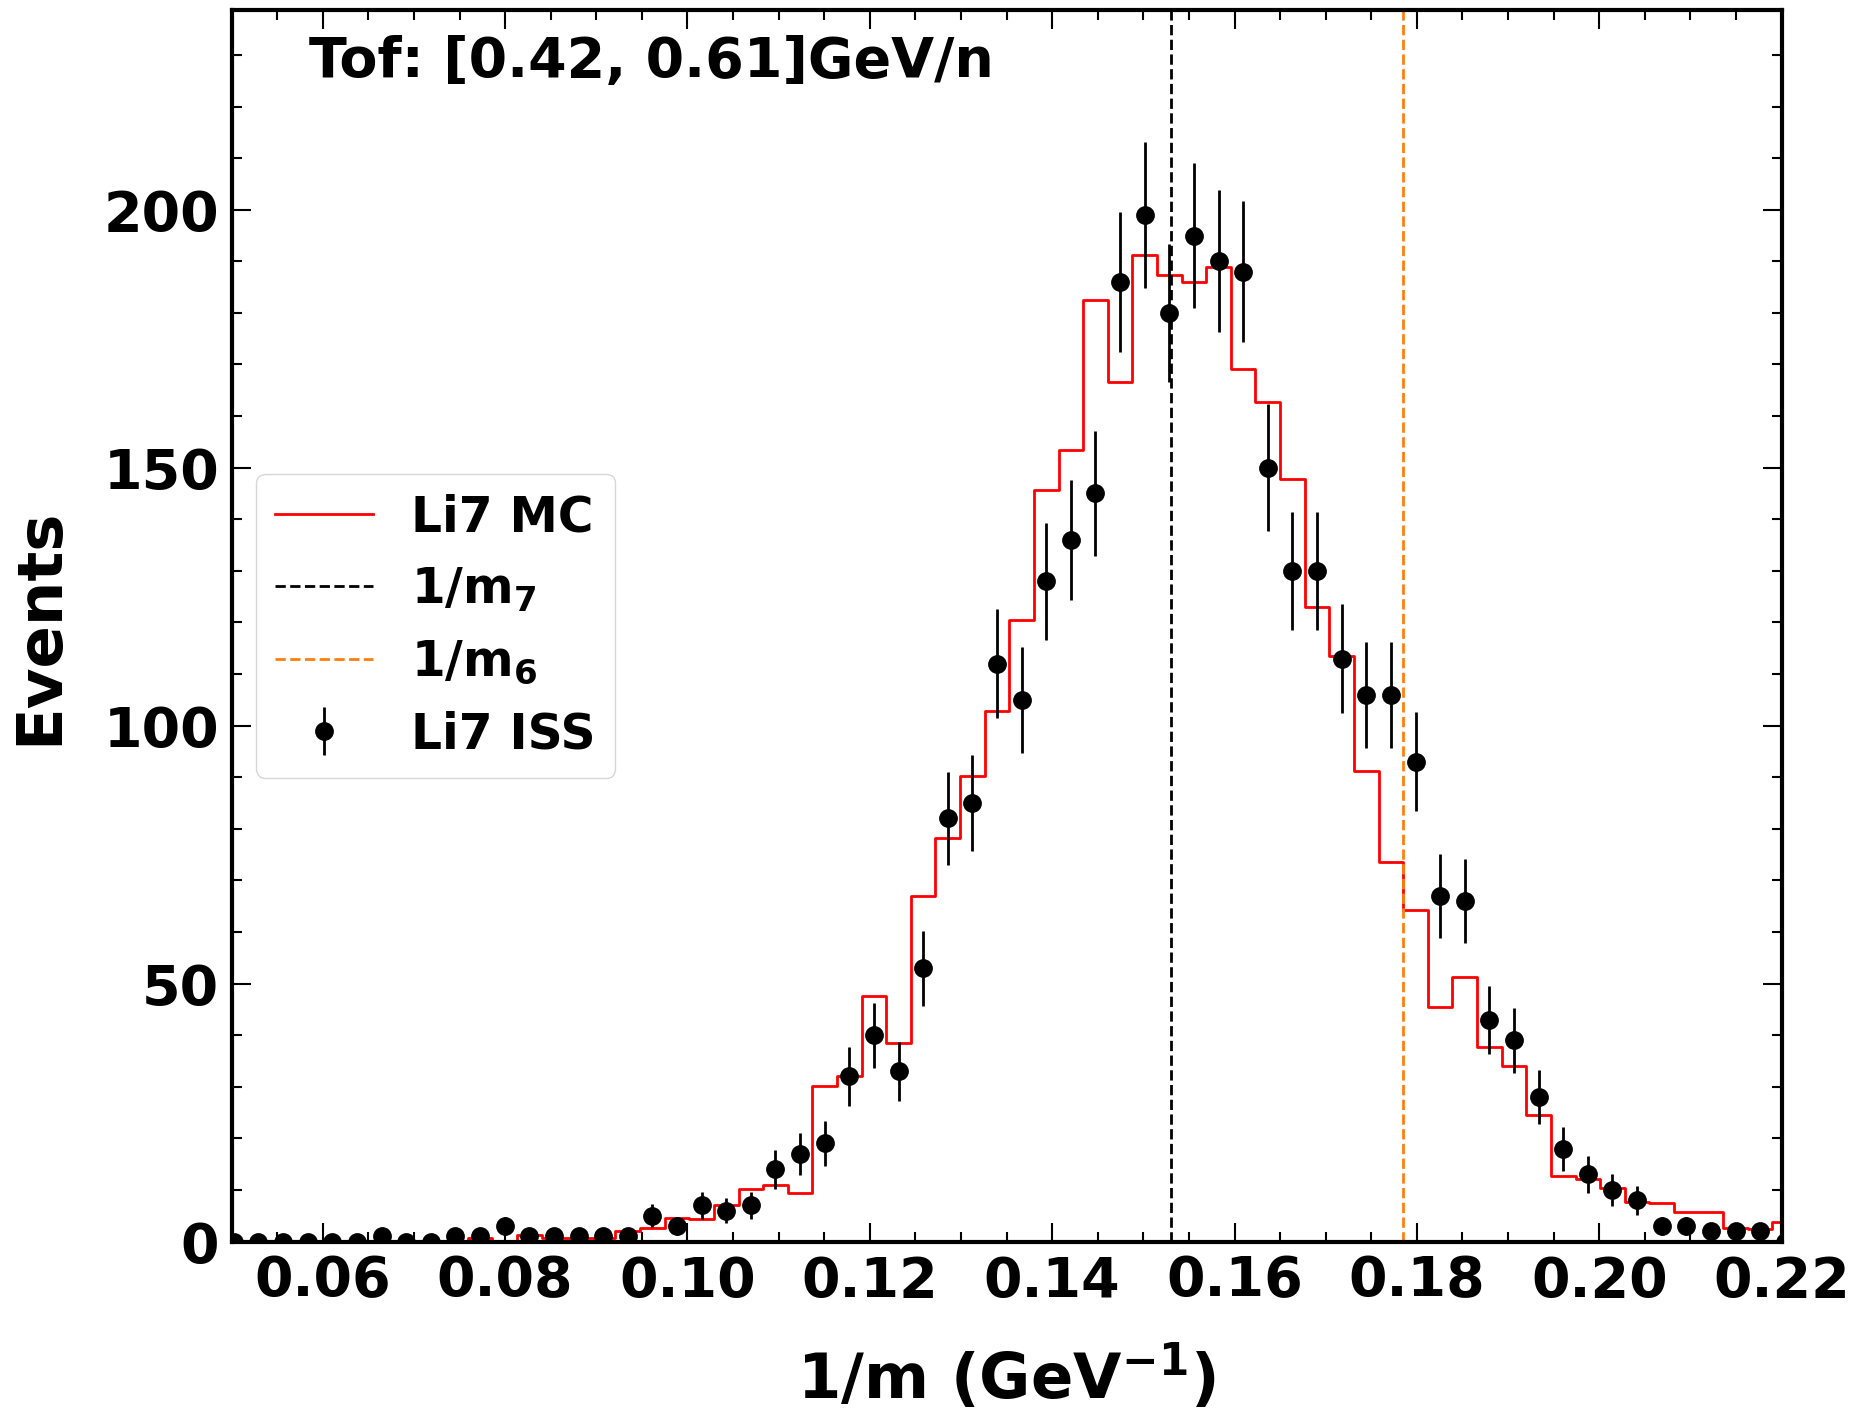

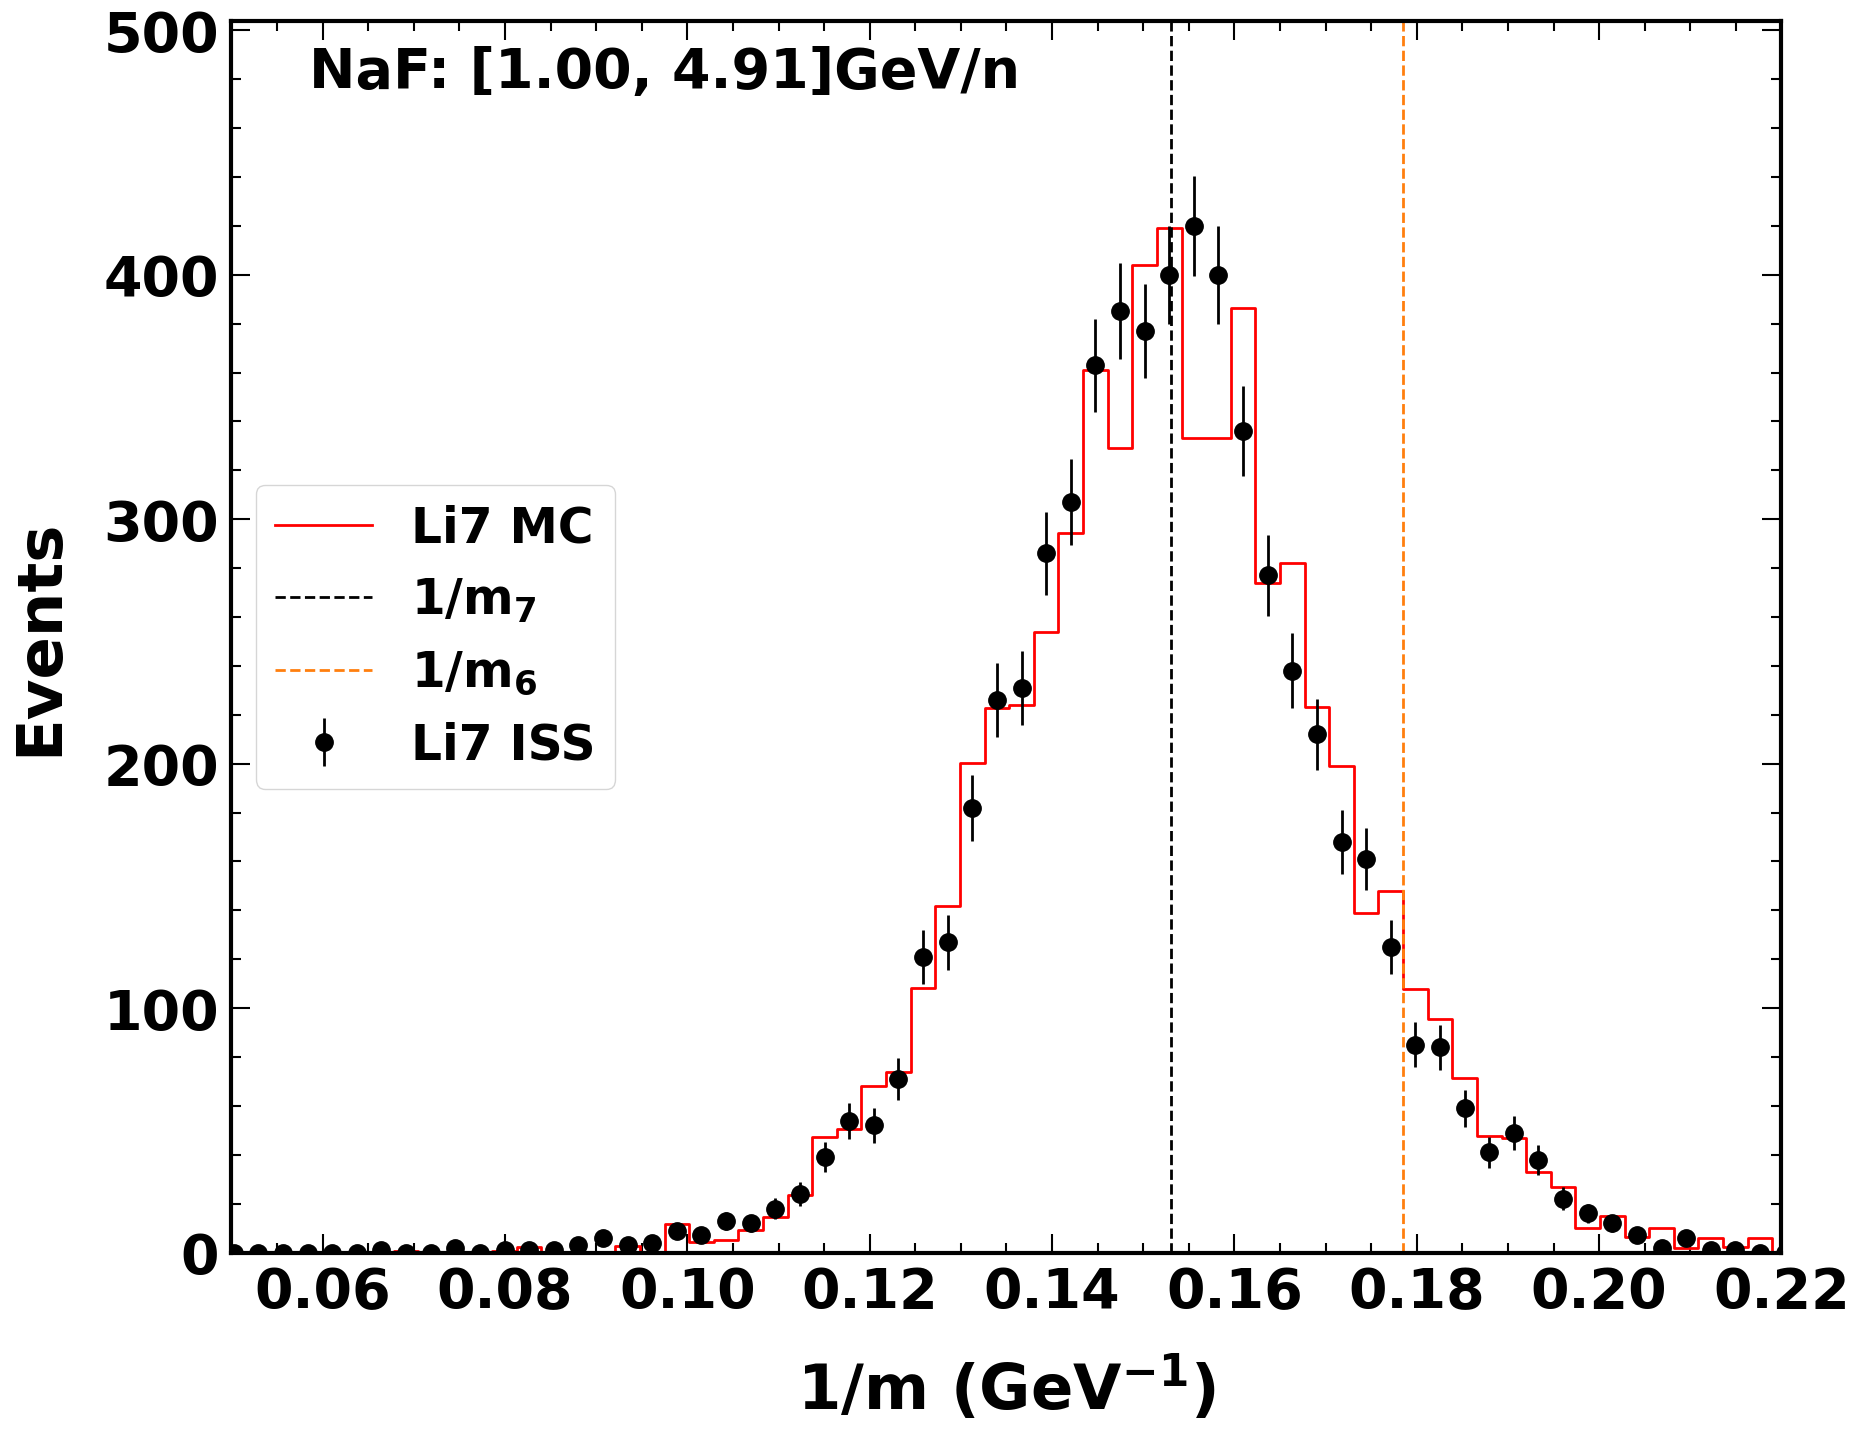

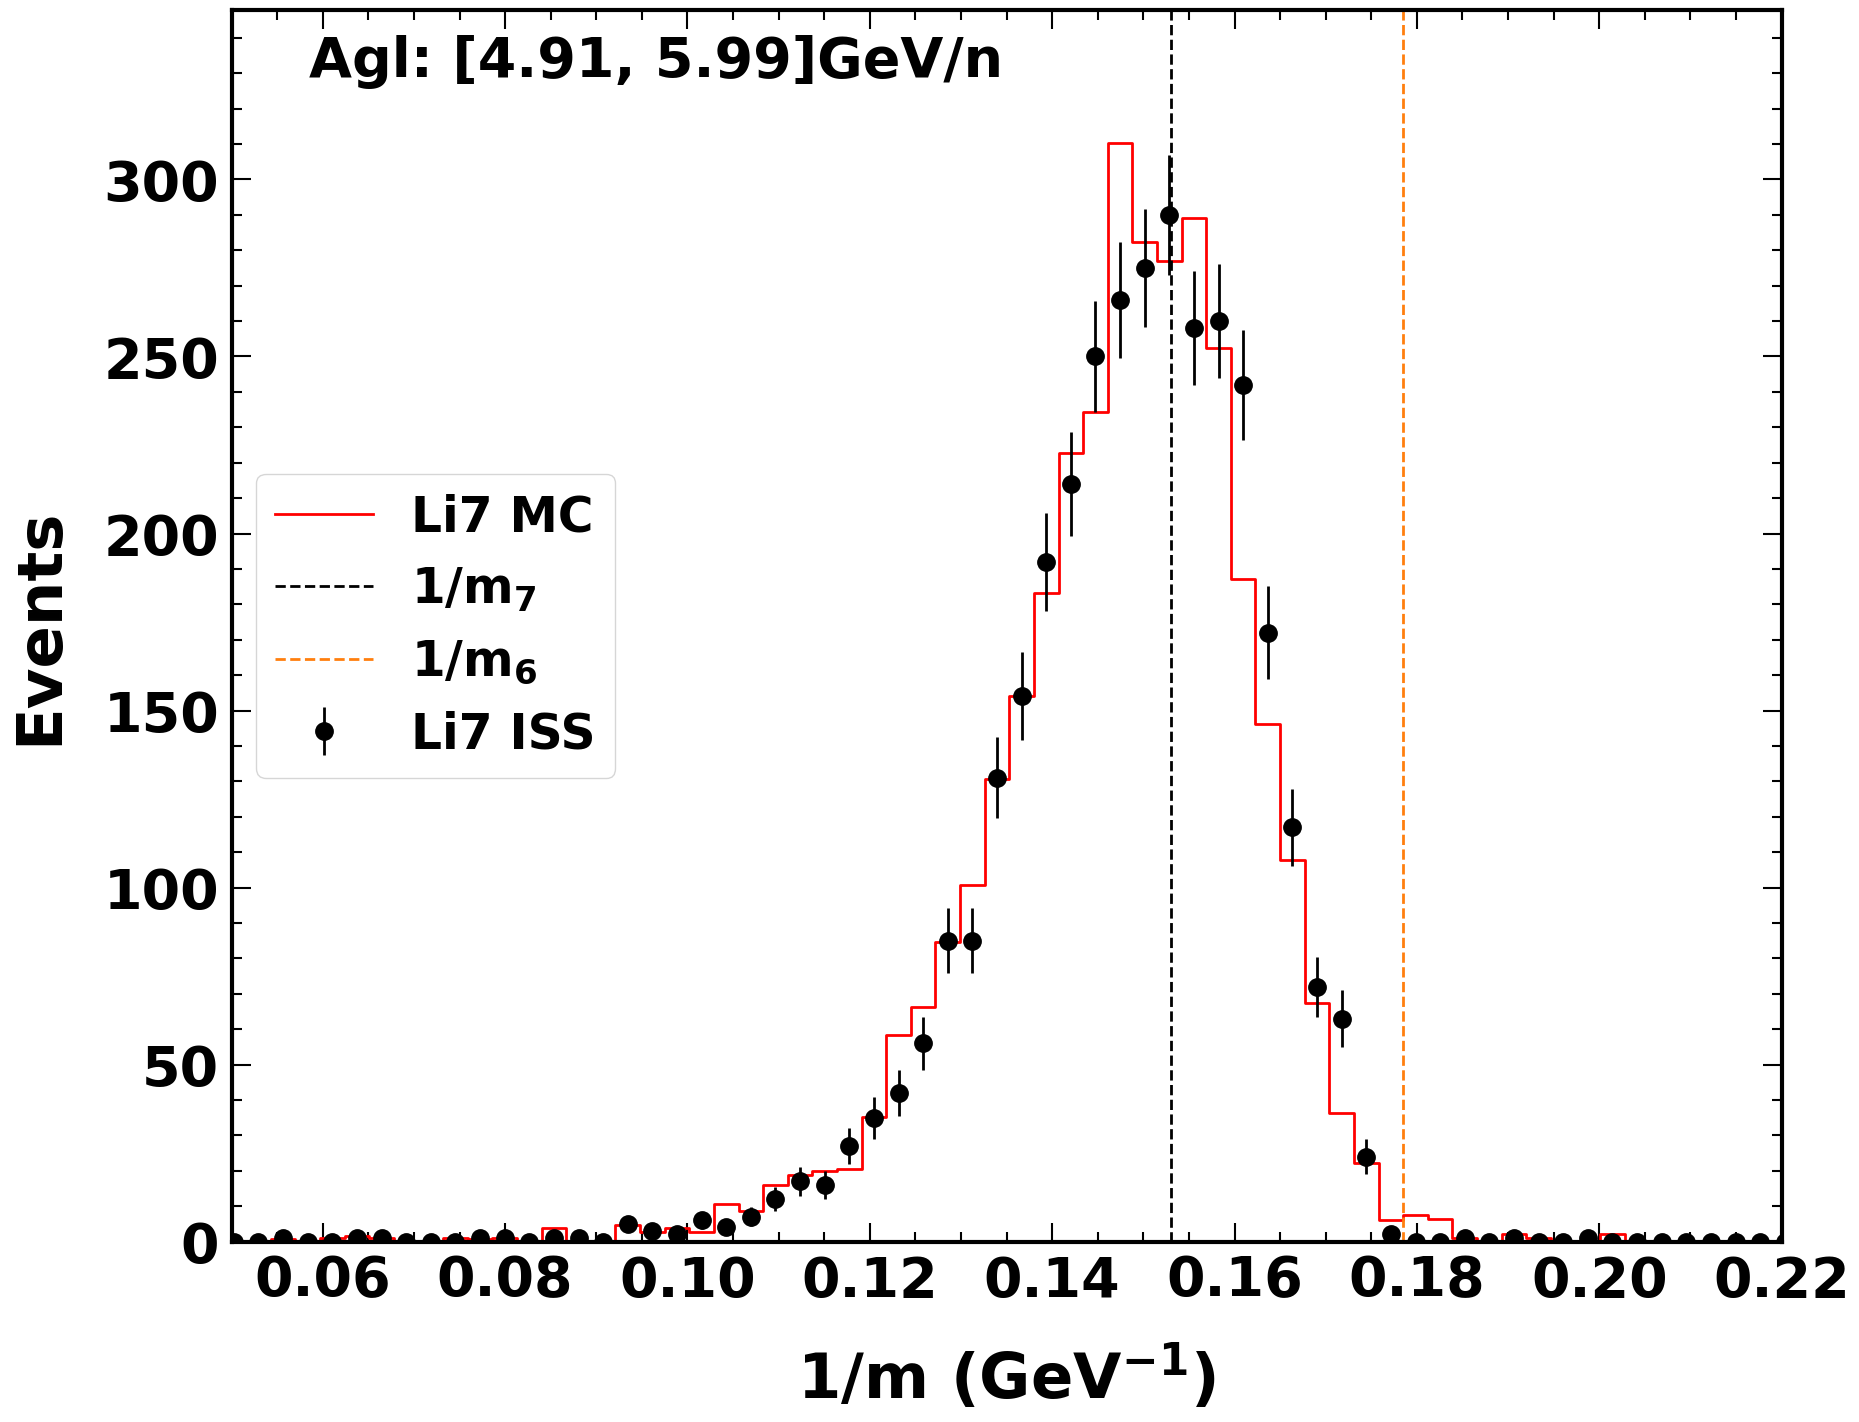

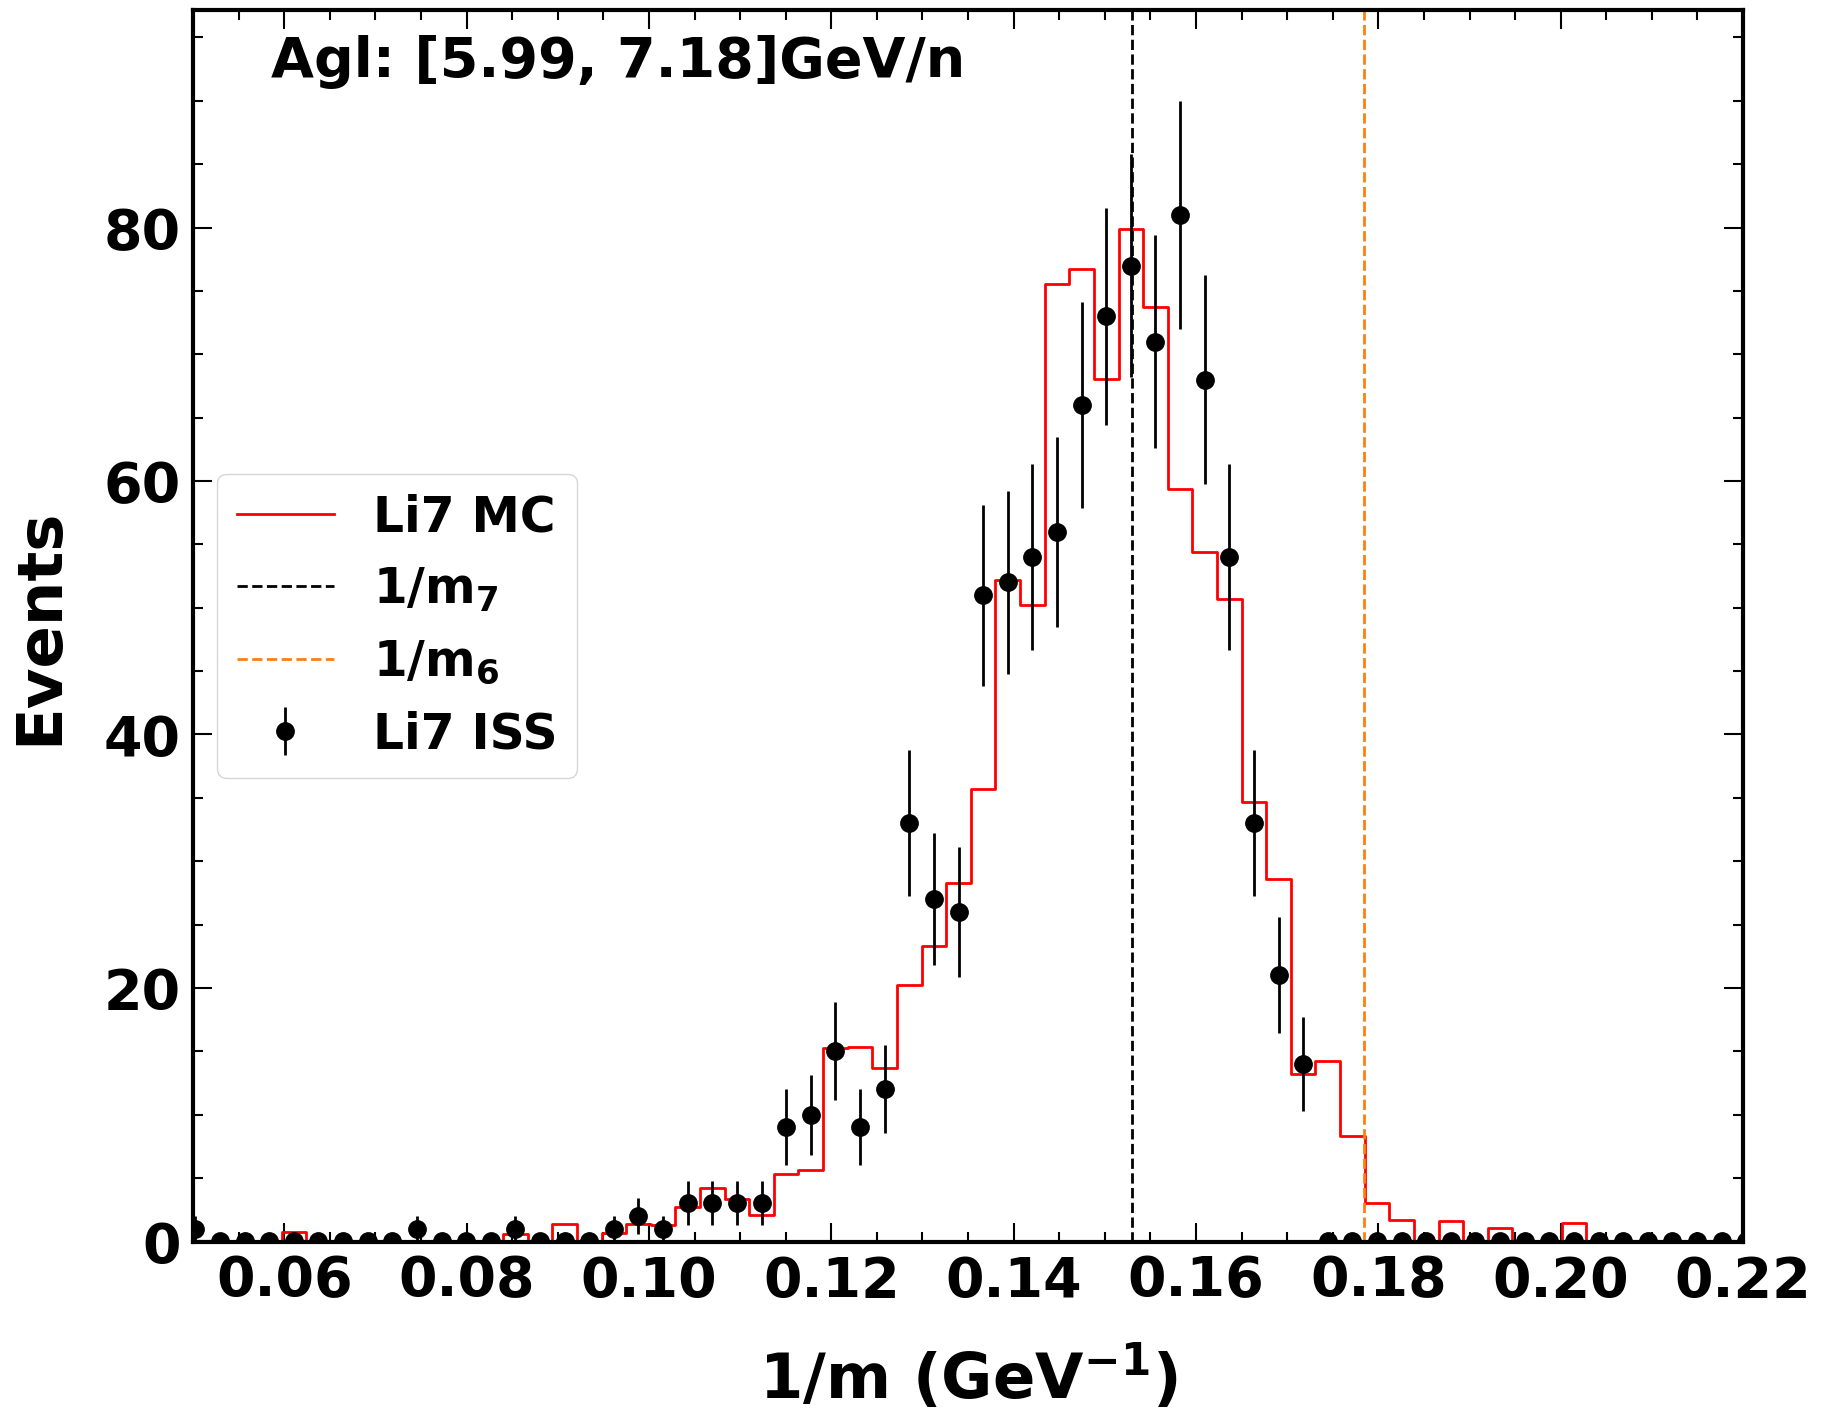

In [81]:
minbin = {'Tof': 1, 'NaF':2, 'Agl':10}
maxbin =  {'Tof':2,  'NaF':3, 'Agl':12}
sigmafactor = {'Tof':2,  'NaF':1.2, 'Agl':1.8}
guess0 = dict(norm=1, mu=0.14, sigma=0.01)
xrange = {'Tof': [0.12, 0.18], 'NaF': [0.12, 0.18], 'Agl': [0.13, 0.175]}
col = {'mc': 'red', 'iss':'black'}
for dec in detectors:
    for ibin in range(minbin[dec], maxbin[dec]):
        fig, ax1 = plt.subplots(1, 1, figsize=(20, 16))
        hist1dmassbin = hist2dmass[dec].project(ibin)
        print(ibin, hist2dmass[dec].binnings[0].bin_centers[ibin])
        bincenter = hist2dmass[dec].binnings[0].bin_centers[ibin]
        binedges = hist2dmass[dec].binnings[0].edges
        hist1dmassbin_iss = hist2dmass_iss[dec].project(ibin)
        #print('iss', sum(hist1dmassbin_iss.values))
        hist1dmassbin.values = hist1dmassbin.values * sum(hist1dmassbin_iss.values)/sum(hist1dmassbin.values)
        plot_histogram_1d(ax1, hist1dmassbin, style="mc", color=col['mc'], label=f'Li7 MC', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2, markersize=25)
        plot_histogram_1d(ax1, hist1dmassbin_iss, style="iss", color=col['iss'], label=f'{iso} ISS', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2, markersize=25)

        set_plot_style(ax1)
        SetAx1Axis(ax1, r'$\mathrm{1/m \ (GeV^{-1})}$', 'Events', 45, xlimrange=[0.05, 0.22], ylimrange=[-0.01, 1.2 * max(hist1dmassbin_iss.values)] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False)
      
        ax1.text(0.05, 0.98, '{}: [{:.2f}, {:.2f}]GeV/n'.format(dec, binedges[ibin], binedges[ibin+1]),  fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      
        
        ax1.axvline(x=1/ISOTOPES_MASS['Li7'], linewidth=2,color='black', linestyle='--', label=r'$\mathrm{1/m_{7}}$') 
        ax1.axvline(x=1/ISOTOPES_MASS['Li6'], linewidth=2,color='tab:orange', linestyle='--', label=r'$\mathrm{1/m_{6}}$') 
        ax1.legend(fontsize=35, loc='center left')
        #ax1.fill_betweenx(np.linspace(-1,1.5 * max(hist1dmassbin_iss.values), 100), 0.134, 0.17, color='tab:blue', alpha=0.1)
        #ax1.axvline(x=1/ISOTOPES_MASS['Li6'], linewidth=2,color='grey', linestyle='--', label=r'$\mathrm{m^{nominal}_{6}}$') 
        #savefig_tofile(fig, plotfile, f"hist_datamc_compare_{dec}{iso}_{ibin}_{figName}", show=True)  
        print(plotfile)
        print(f"histmc_{dec}{iso}_{ibin}_Li7")
         
        plotfile = '/home/manbing/Documents/lithiumanalysis/slides/Presentation_27May'
        savefig_tofile(fig, plotfile, f"histLi7_{dec}{iso}_{ibin}", show=True) 
       

#Test fit range  !!!Fit Results can have small differences by changing fit range xrange

1 0.5144
/home/manbing/Documents/lithiumanalysis/slides/Presentation_27May
histmc_TofLi7_1_Li7
<ValueView norm=8.459428820717621 mu=0.1532103244613067 sigma=0.017760478073690005>
<ValueView norm=8.295314553223168 mu=0.1541702965979753 sigma=-0.01780300724401425>
1.00626571440302
/home/manbing/Documents/lithiumanalysis/slides/Presentation_27May
Tof number events: 3293.5583143157946
2 2.9573
/home/manbing/Documents/lithiumanalysis/slides/plots_16May
histmc_NaFLi7_2_Li7
<ValueView norm=16.49201392960683 mu=0.1527494063098799 sigma=-0.017790289790626888>
<ValueView norm=15.414574424980204 mu=0.15157729826613506 sigma=0.015414781369131686>
0.9923265950941439
/home/manbing/Documents/lithiumanalysis/slides/plots_16May
NaF number events: 6084.20875338828
10 5.4516
/home/manbing/Documents/lithiumanalysis/slides/plots_16May
histmc_AglLi7_10_Li7
<ValueView norm=8.934960455497428 mu=0.15020272591859982 sigma=-0.012434448218013264>
<ValueView norm=9.51352241524954 mu=0.15148424094779422 sigma=-0.01

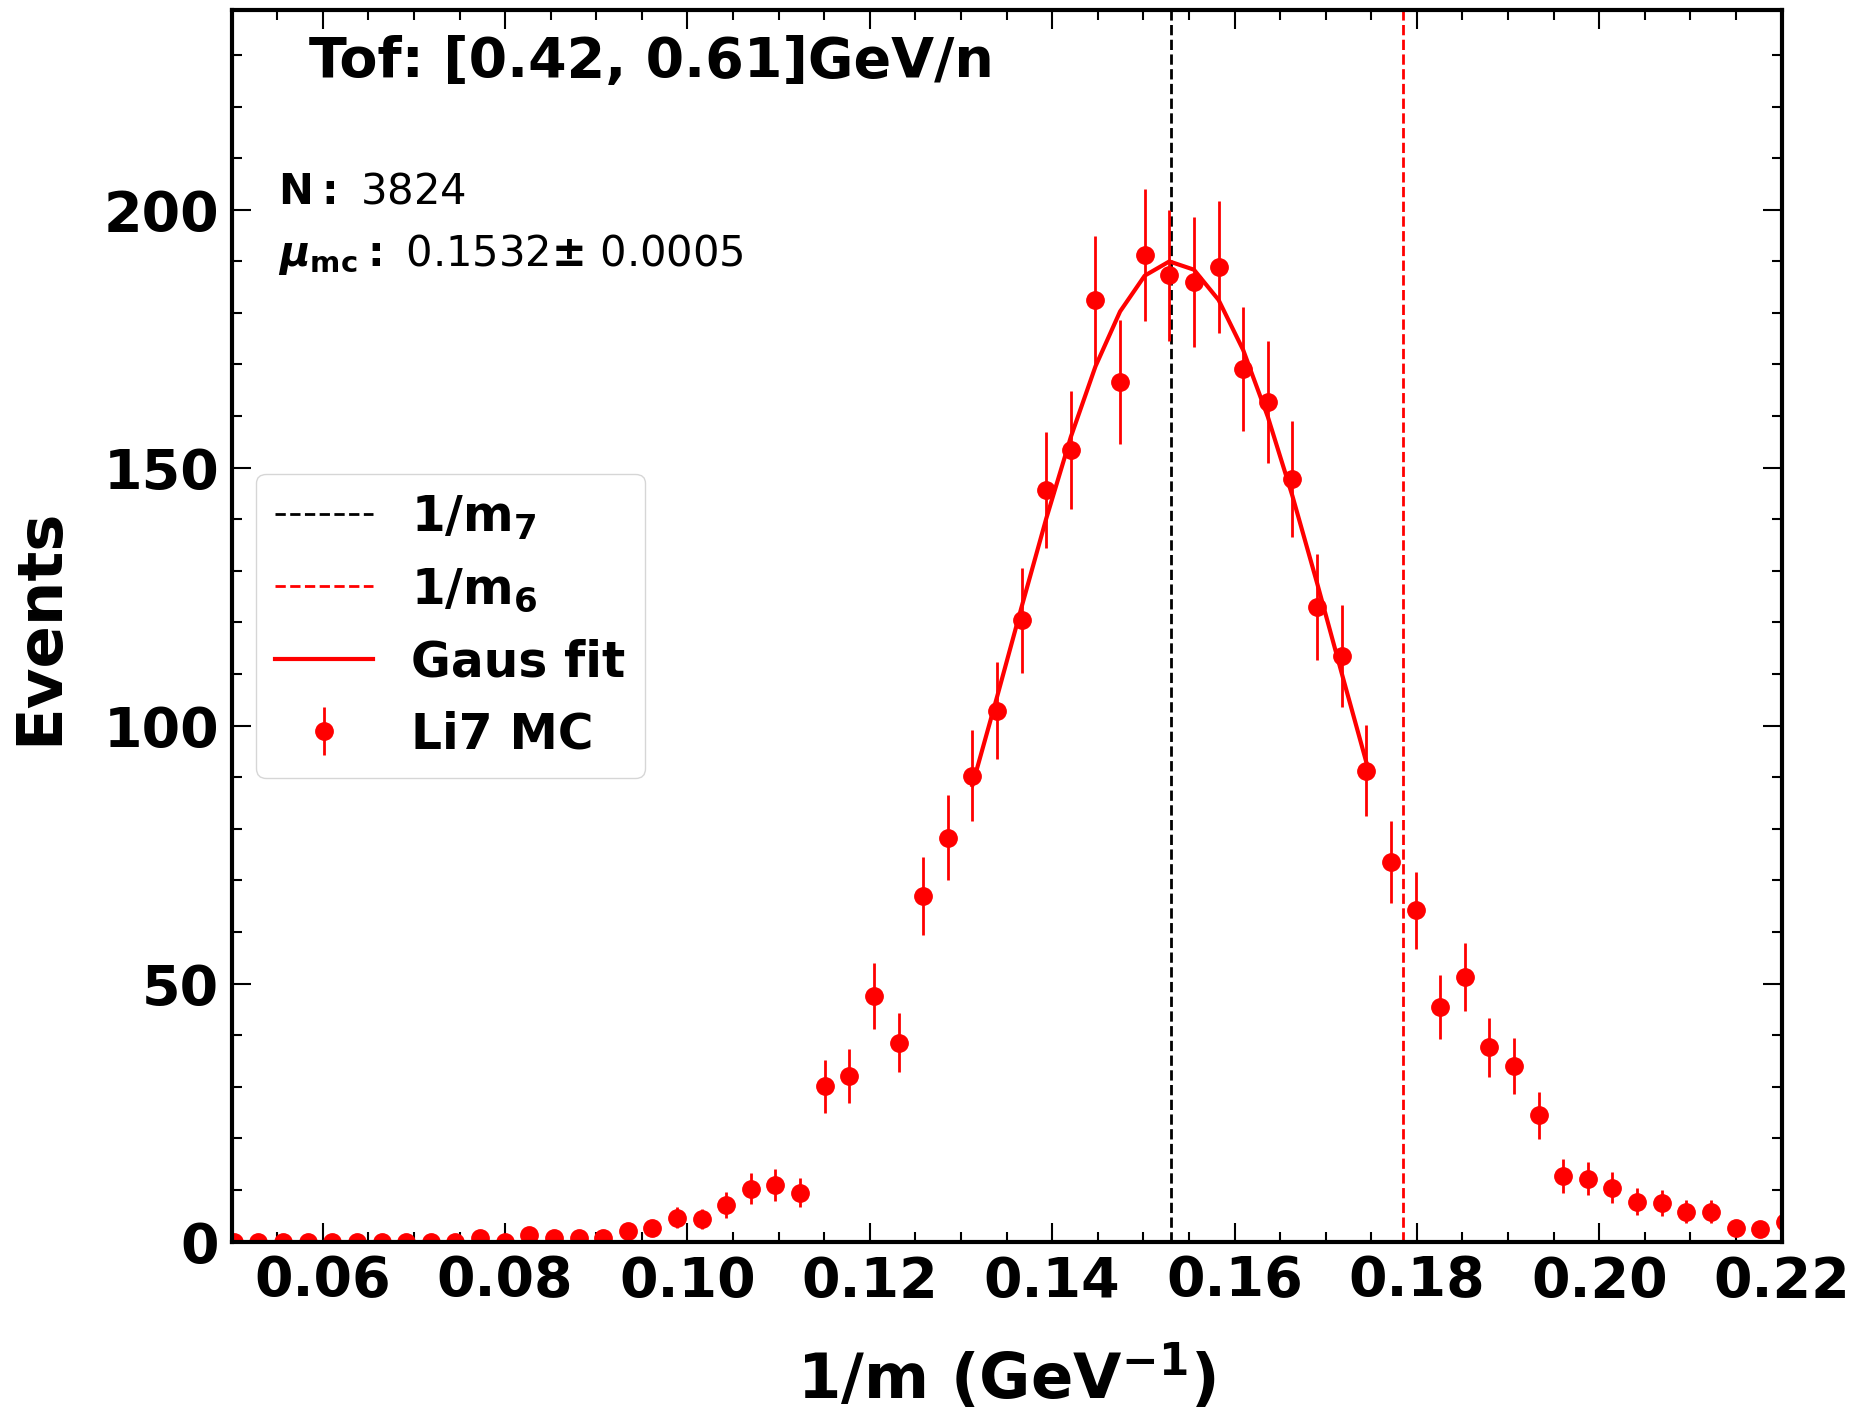

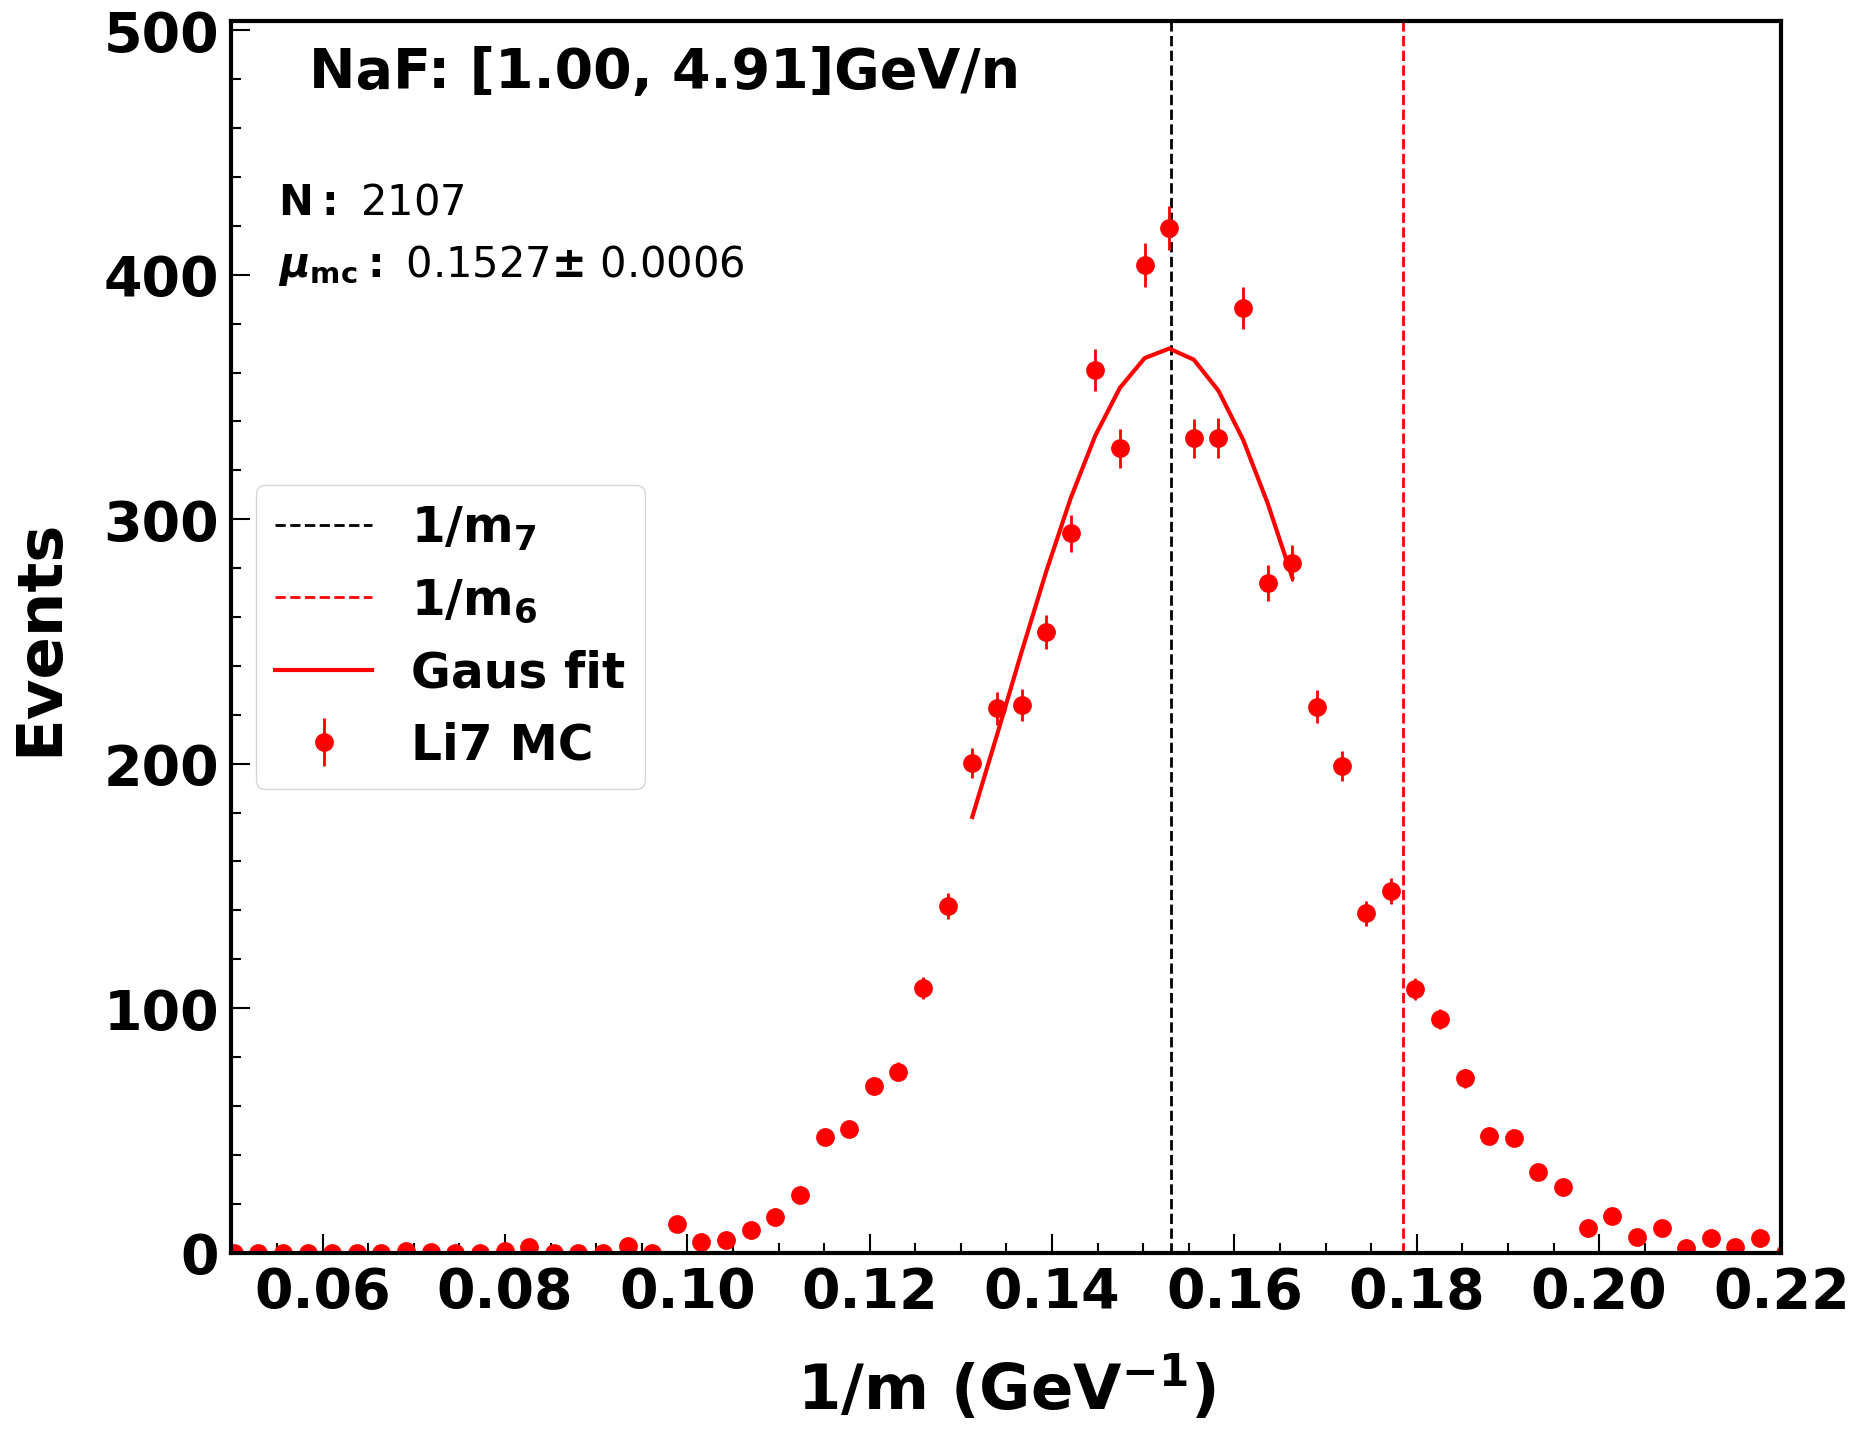

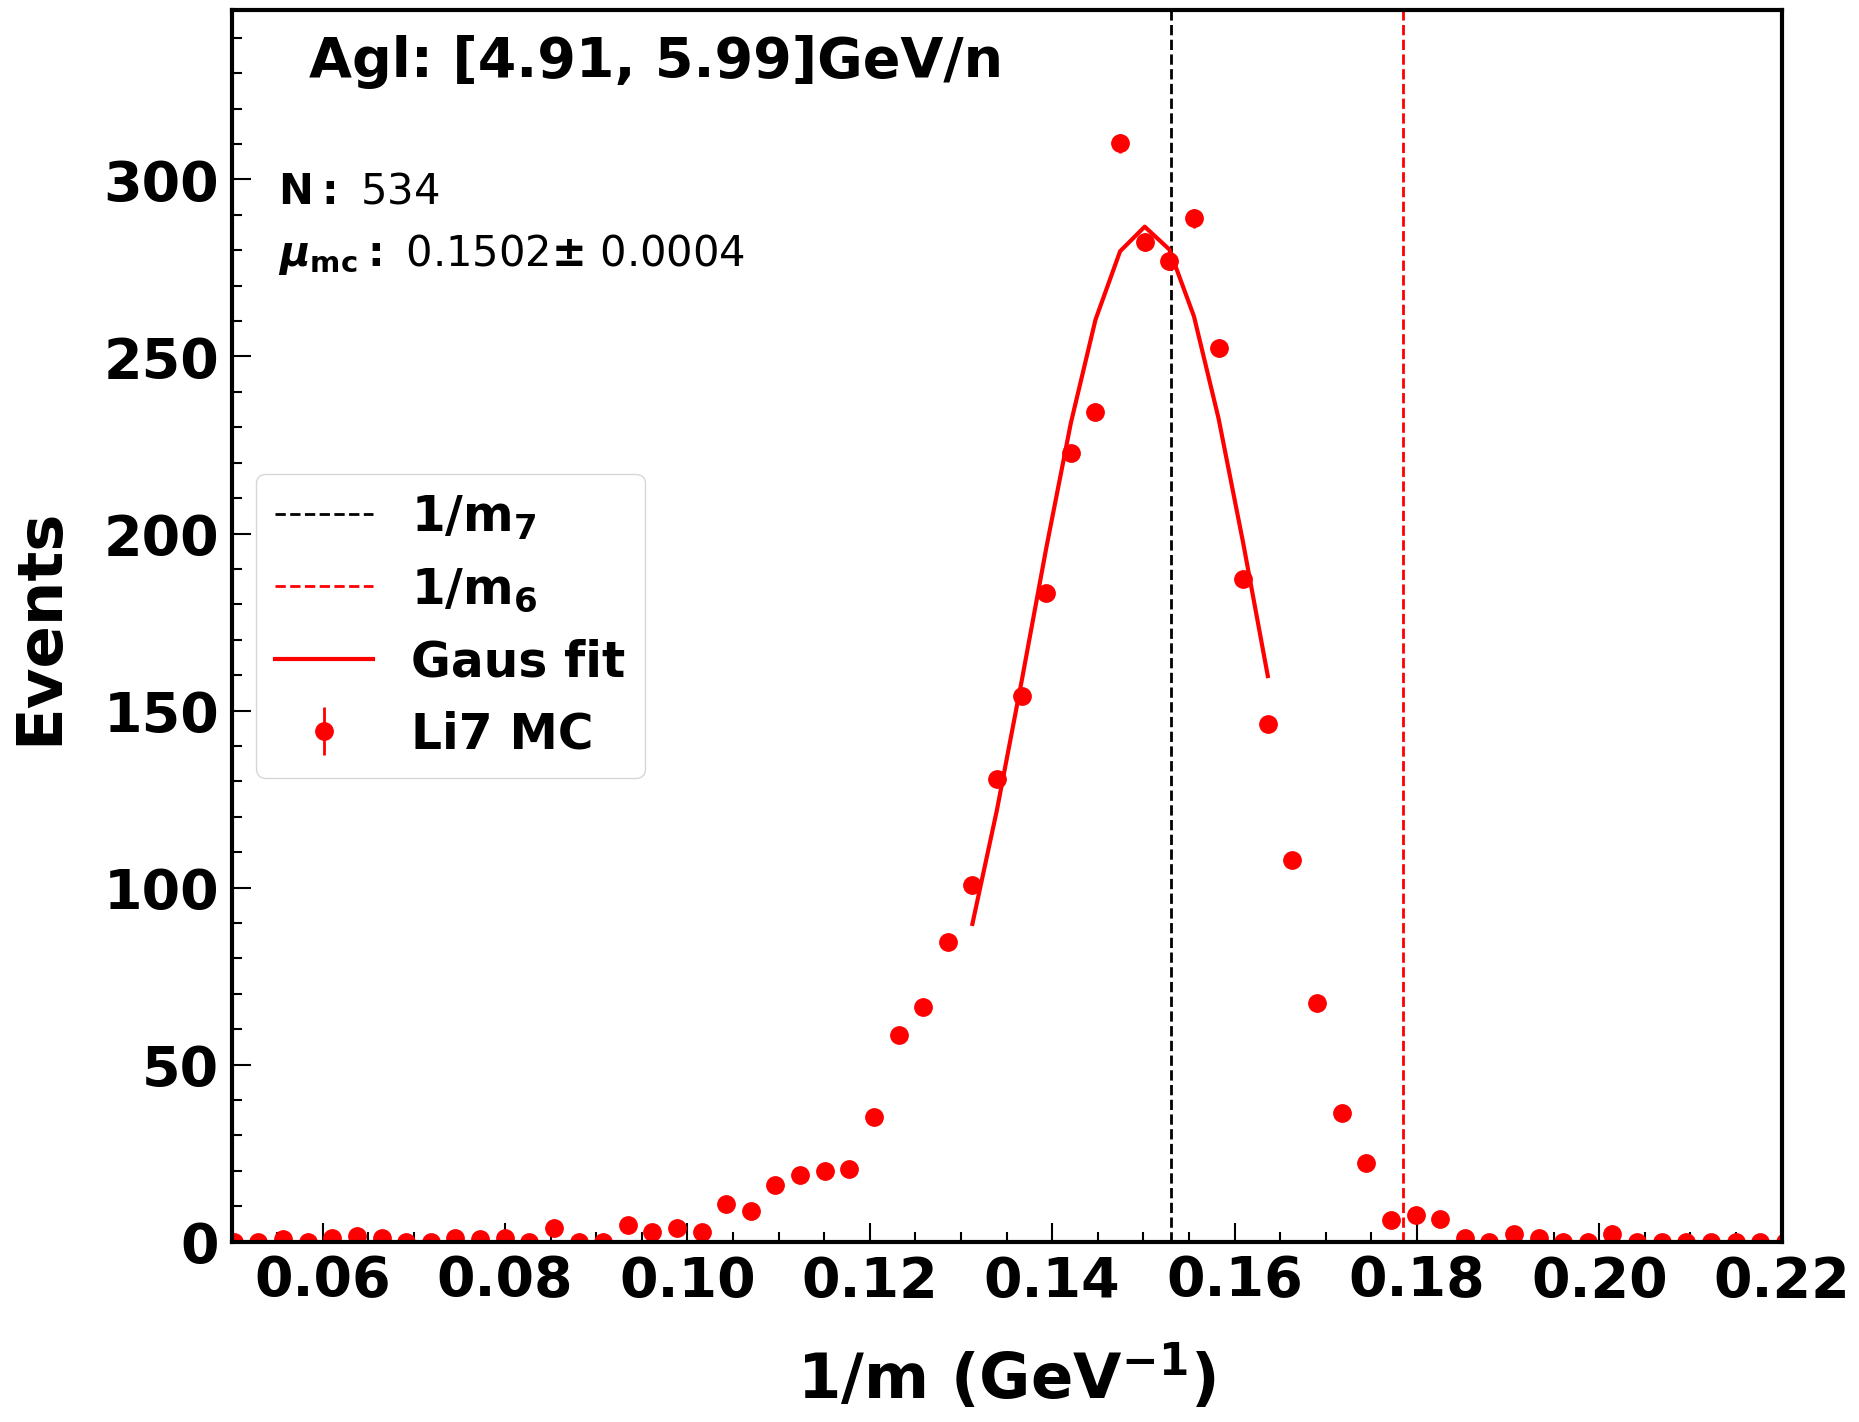

In [82]:
minbin = {'Tof': 1, 'NaF':2, 'Agl':10}
maxbin =  {'Tof':2,  'NaF':3, 'Agl':11}
sigmafactor = {'Tof':3,  'NaF':2, 'Agl':1.8}
guess0 = dict(norm=1, mu=0.14, sigma=0.01)
xrange = {'Tof': [0.13, 0.176], 'NaF': [0.13, 0.17], 'Agl': [0.13, 0.166]}

graph_mean_mc = {}
graph_mean_data = {}
drawiss = False

for dec in detectors:
    energy_binvalues = hist2dmass[dec].binnings[0].bin_centers[minbin[dec]:maxbin[dec]]
    graph_mean_mc[dec] = MGraph(energy_binvalues, np.zeros_like(energy_binvalues), yerrs=np.zeros_like(energy_binvalues))
    graph_mean_data[dec] = MGraph(energy_binvalues, np.zeros_like(energy_binvalues), yerrs=np.zeros_like(energy_binvalues))

    for ip, ibin in enumerate(range(minbin[dec], maxbin[dec])):
        fig, ax1 = plt.subplots(1, 1, figsize=(20, 16))
        hist1dmassbin = hist2dmass[dec].project(ibin)
        print(ibin, hist2dmass[dec].binnings[0].bin_centers[ibin])
        bincenter = hist2dmass[dec].binnings[0].bin_centers[ibin]
        binedges = hist2dmass[dec].binnings[0].edges
        
        
        hist1dmassbin_iss = hist2dmass_iss[dec].project(ibin)
        #print('iss', sum(hist1dmassbin_iss.values))
        if not drawiss:
            ax1.text(0.03, 0.87, f"$\mathrm{{N}}:$ {np.sum(hist1dmassbin.values):.0f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=col['iss'], weight='normal')  
        hist1dmassbin.values = hist1dmassbin.values * sum(hist1dmassbin_iss.values)/sum(hist1dmassbin.values)
        
        set_plot_style(ax1)
        
       
        ax1.text(0.05, 0.98, '{}: [{:.2f}, {:.2f}]GeV/n'.format(dec, binedges[ibin], binedges[ibin+1]),  fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      
        ax1.axvline(x=1/ISOTOPES_MASS['Li7'], linewidth=2,color='black', linestyle='--', label=r'$\mathrm{1/m_{7}}$') 
        ax1.axvline(x=1/ISOTOPES_MASS['Li6'], linewidth=2,color='red', linestyle='--', label=r'$\mathrm{1/m_{6}}$') 
    
        #ax1.fill_betweenx(np.linspace(-1,1.5 * max(hist1dmassbin_iss.values), 100), 0.134, 0.17, color='tab:blue', alpha=0.1)
        #ax1.axvline(x=1/ISOTOPES_MASS['Li6'], linewidth=2,color='grey', linestyle='--', label=r'$\mathrm{m^{nominal}_{6}}$') 
        #savefig_tofile(fig, plotfile, f"hist_datamc_compare_{dec}{iso}_{ibin}_{figName}", show=True)  
        print(plotfile)
        print(f"histmc_{dec}{iso}_{ibin}_Li7")
        xbinrange = hist1dmassbin_iss.binnings[0].get_indices(xrange[dec])
        xedges = hist1dmassbin_iss.binnings[0].edges[xbinrange[0]:xbinrange[1]+1]
        xvalue = hist1dmassbin_iss.binnings[0].bin_centers[xbinrange[0]:xbinrange[1]]
        yvalue = hist1dmassbin_iss.values[xbinrange[0]:xbinrange[1]]
        yvalueserr = np.sqrt(yvalue)
        yvalueserr[yvalueserr==0] = 0.0001
        par_iss, parerr_iss = minuitfit_Chi(xvalue, yvalue, yvalueserr,normalized_gaussian, guess0)
        fit_y_iss = normalized_gaussian(xvalue, *par_iss) 
        
        
        yvalue_mc = hist1dmassbin.values[xbinrange[0]:xbinrange[1]]
        yvalueserr_mc = np.sqrt(yvalue_mc)
        yvalueserr_mc[yvalueserr_mc==0] = 0.0001
        par_mc, parerr_mc = minuitfit_Chi(xvalue, yvalue_mc, yvalueserr_mc ,normalized_gaussian, guess0)
        fit_y_mc = normalized_gaussian(xvalue, *par_mc) 
        print(par_mc)
        print(par_iss)
        print(par_iss['mu']/par_mc['mu'])
        
        #ax1.text(0.03, 0.98, f'Data ', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=isscolor, weight='normal')  
        #ax1.text(0.03, 0.8, rf"\\mu: {par_iss['mu']:.4f}$\\pm$ {parerr_iss['mu']:.4f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=col['iss'], weight='normal')  
        
        graph_mean_mc[dec].yvalues[ip] = par_mc['mu']
        graph_mean_mc[dec].yerrs[ip] = parerr_mc['mu']
        graph_mean_data[dec].yvalues[ip] = par_iss['mu']
        graph_mean_data[dec].yerrs[ip] = parerr_iss['mu']
        
        if drawiss:
            plot_histogram_1d(ax1, hist1dmassbin_iss, style="iss", color=col['iss'], label=f'{iso} ISS', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2, markersize=25)
            ax1.plot(xvalue, fit_y_iss, '-', linewidth=3, color=col['iss'], label='Gaus fit')
            ax1.text(0.03, 0.87, f"$\mathrm{{N}}:$ {np.sum(hist1dmassbin_iss.values):.0f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=col['iss'], weight='normal')  
            ax1.text(0.03, 0.82, f"$\\mu_{{\mathrm{{data}} }}:$ {par_iss['mu']:.4f}$\\pm$ {parerr_iss['mu']:.4f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=col['iss'], weight='normal')  
        
        else:
            plot_histogram_1d(ax1, hist1dmassbin, style="iss", color=col['mc'], label=f'Li7 MC', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2, markersize=25)
            ax1.plot(xvalue, fit_y_mc, '-', linewidth=3, color=col['mc'], label='Gaus fit')
            ax1.text(0.03, 0.82, f"$\\mu_{{\mathrm{{mc}} }}:$ {par_mc['mu']:.4f}$\\pm$ {parerr_mc['mu']:.4f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=col['iss'], weight='normal')  
            
        print(plotfile)
        SetAx1Axis(ax1, r'$\mathrm{1/m \ (GeV^{-1})}$', 'Events', 45, xlimrange=[0.05, 0.22], ylimrange=[-0.01, 1.2 * max(hist1dmassbin_iss.values)] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False)
        ax1.legend(fontsize=35, loc='center left')
        print(dec, 'number events:', np.sum(hist1dmassbin.values[10:90]))
        plotfile='/home/manbing/Documents/lithiumanalysis/slides/plots_16May'
        if drawiss:
            savefig_tofile(fig, plotfile, f"histiss_{dec}{iso}_{ibin}_fit_iss", show=True) 
        else:
            savefig_tofile(fig, plotfile, f"histiss_{dec}{iso}_{ibin}_fit_mc", show=True) 
       

1 0.5144
/home/manbing/Documents/lithiumanalysis/slides/plots_16May
histmc_TofLi7_1_Li7
<ValueView norm=8.46266281158704 mu=0.15330256328624714 sigma=0.01776996225596459>
<ValueView norm=8.015674437508084 mu=0.15399325897068752 sigma=0.016994109493455593>
1.004505441198336
/home/manbing/Documents/lithiumanalysis/slides/plots_16May
Tof number events: 3293.5583143157946
2 2.9573
/home/manbing/Documents/lithiumanalysis/slides/plots_16May
histmc_NaFLi7_2_Li7
<ValueView norm=15.668079729155055 mu=0.15270222114525495 sigma=0.016659601355075722>
<ValueView norm=15.192643251411974 mu=0.15175932427586872 sigma=0.015092090169505171>
0.9938252576660996
/home/manbing/Documents/lithiumanalysis/slides/plots_16May
NaF number events: 6084.20875338828
10 5.4516
/home/manbing/Documents/lithiumanalysis/slides/plots_16May
histmc_AglLi7_10_Li7
<ValueView norm=8.286992174209049 mu=0.15071189128363807 sigma=0.011149078090784017>
<ValueView norm=9.433063012543364 mu=0.15155712995269444 sigma=0.013294469456749

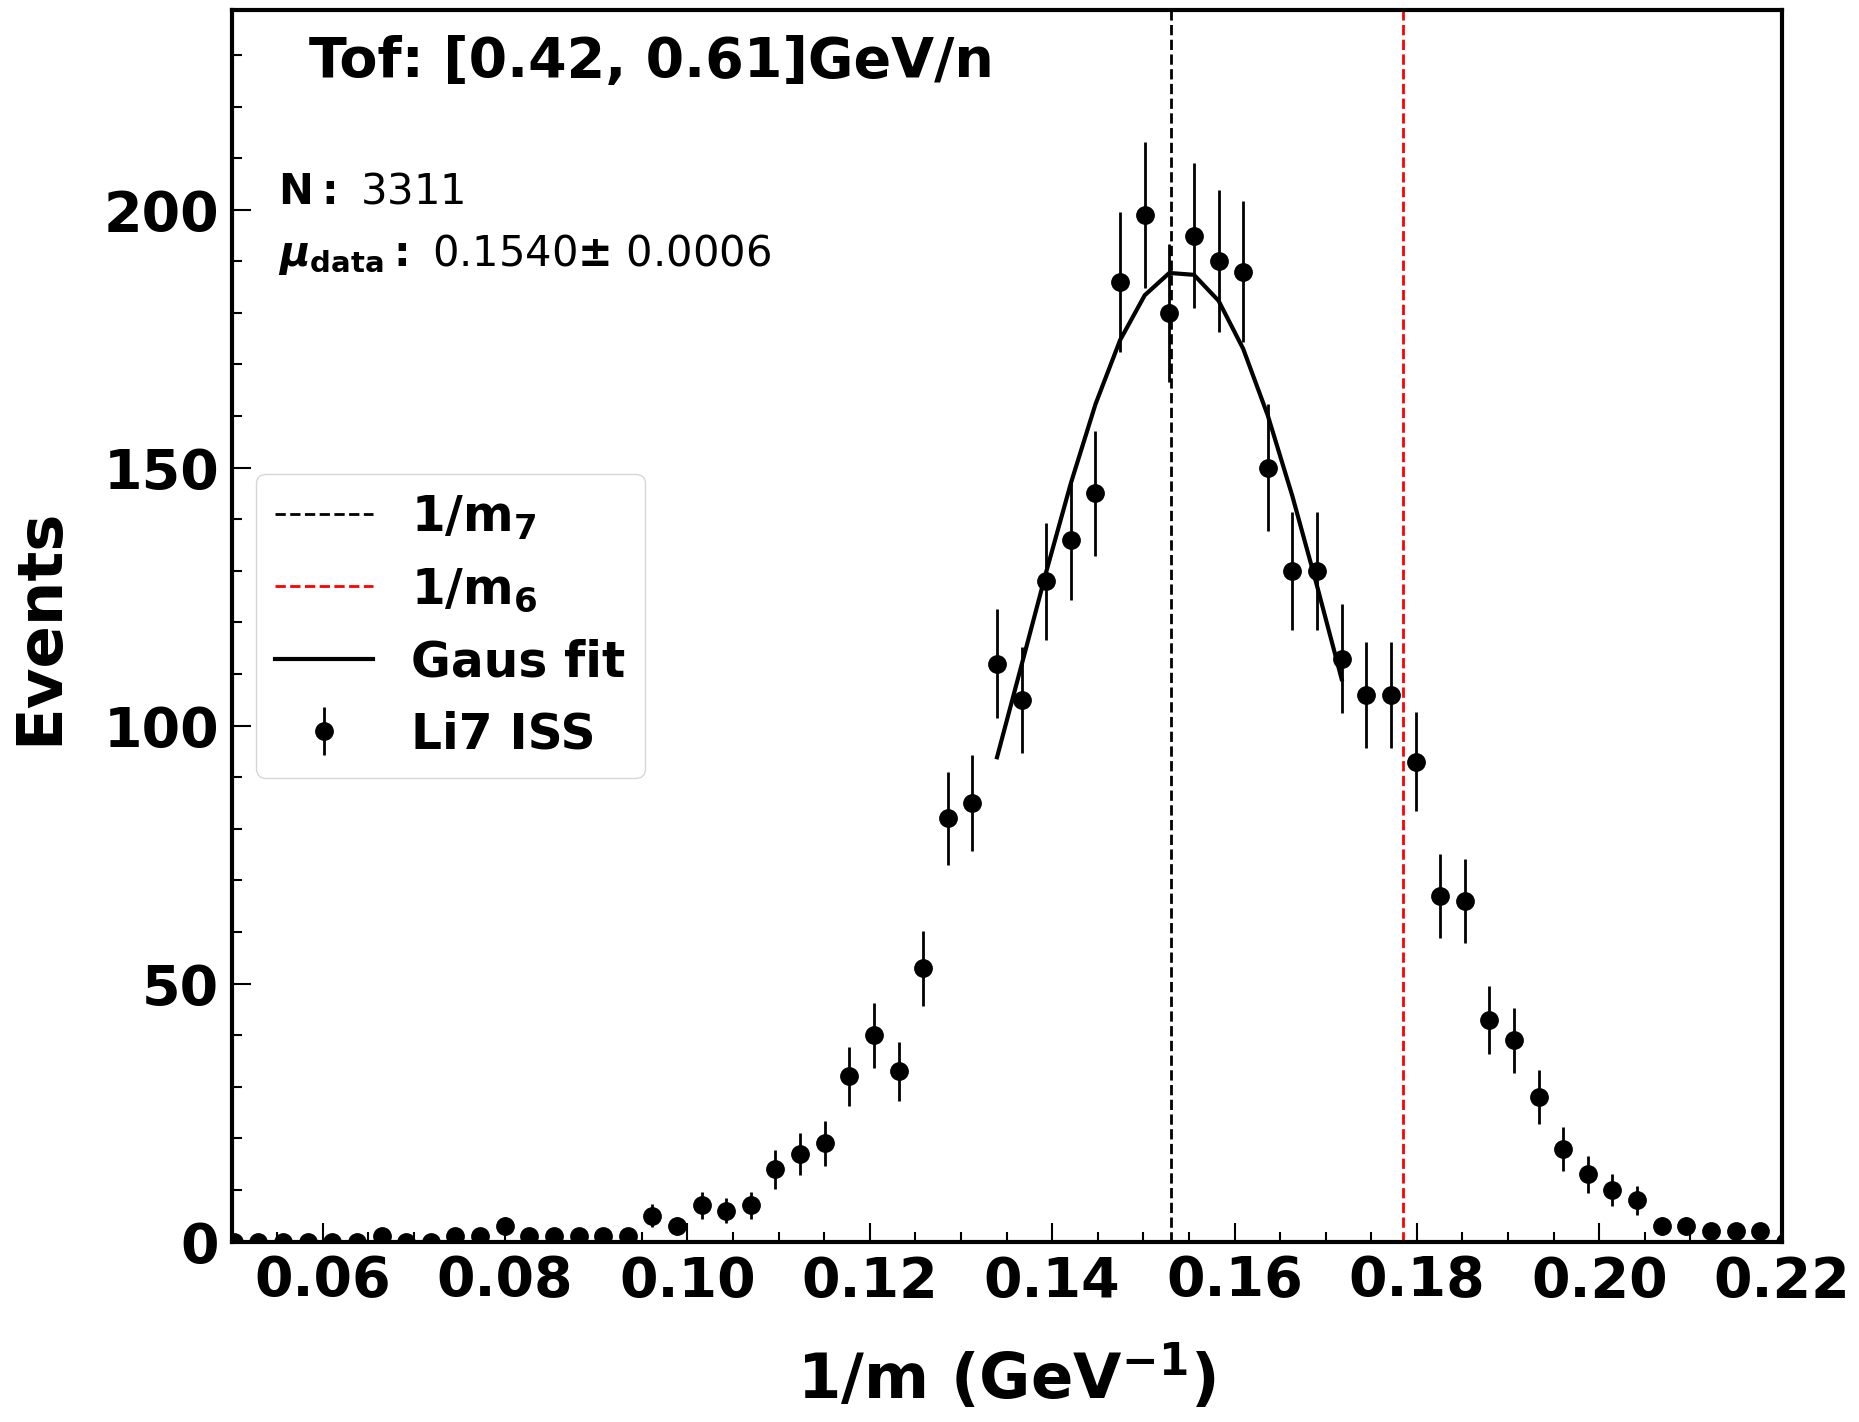

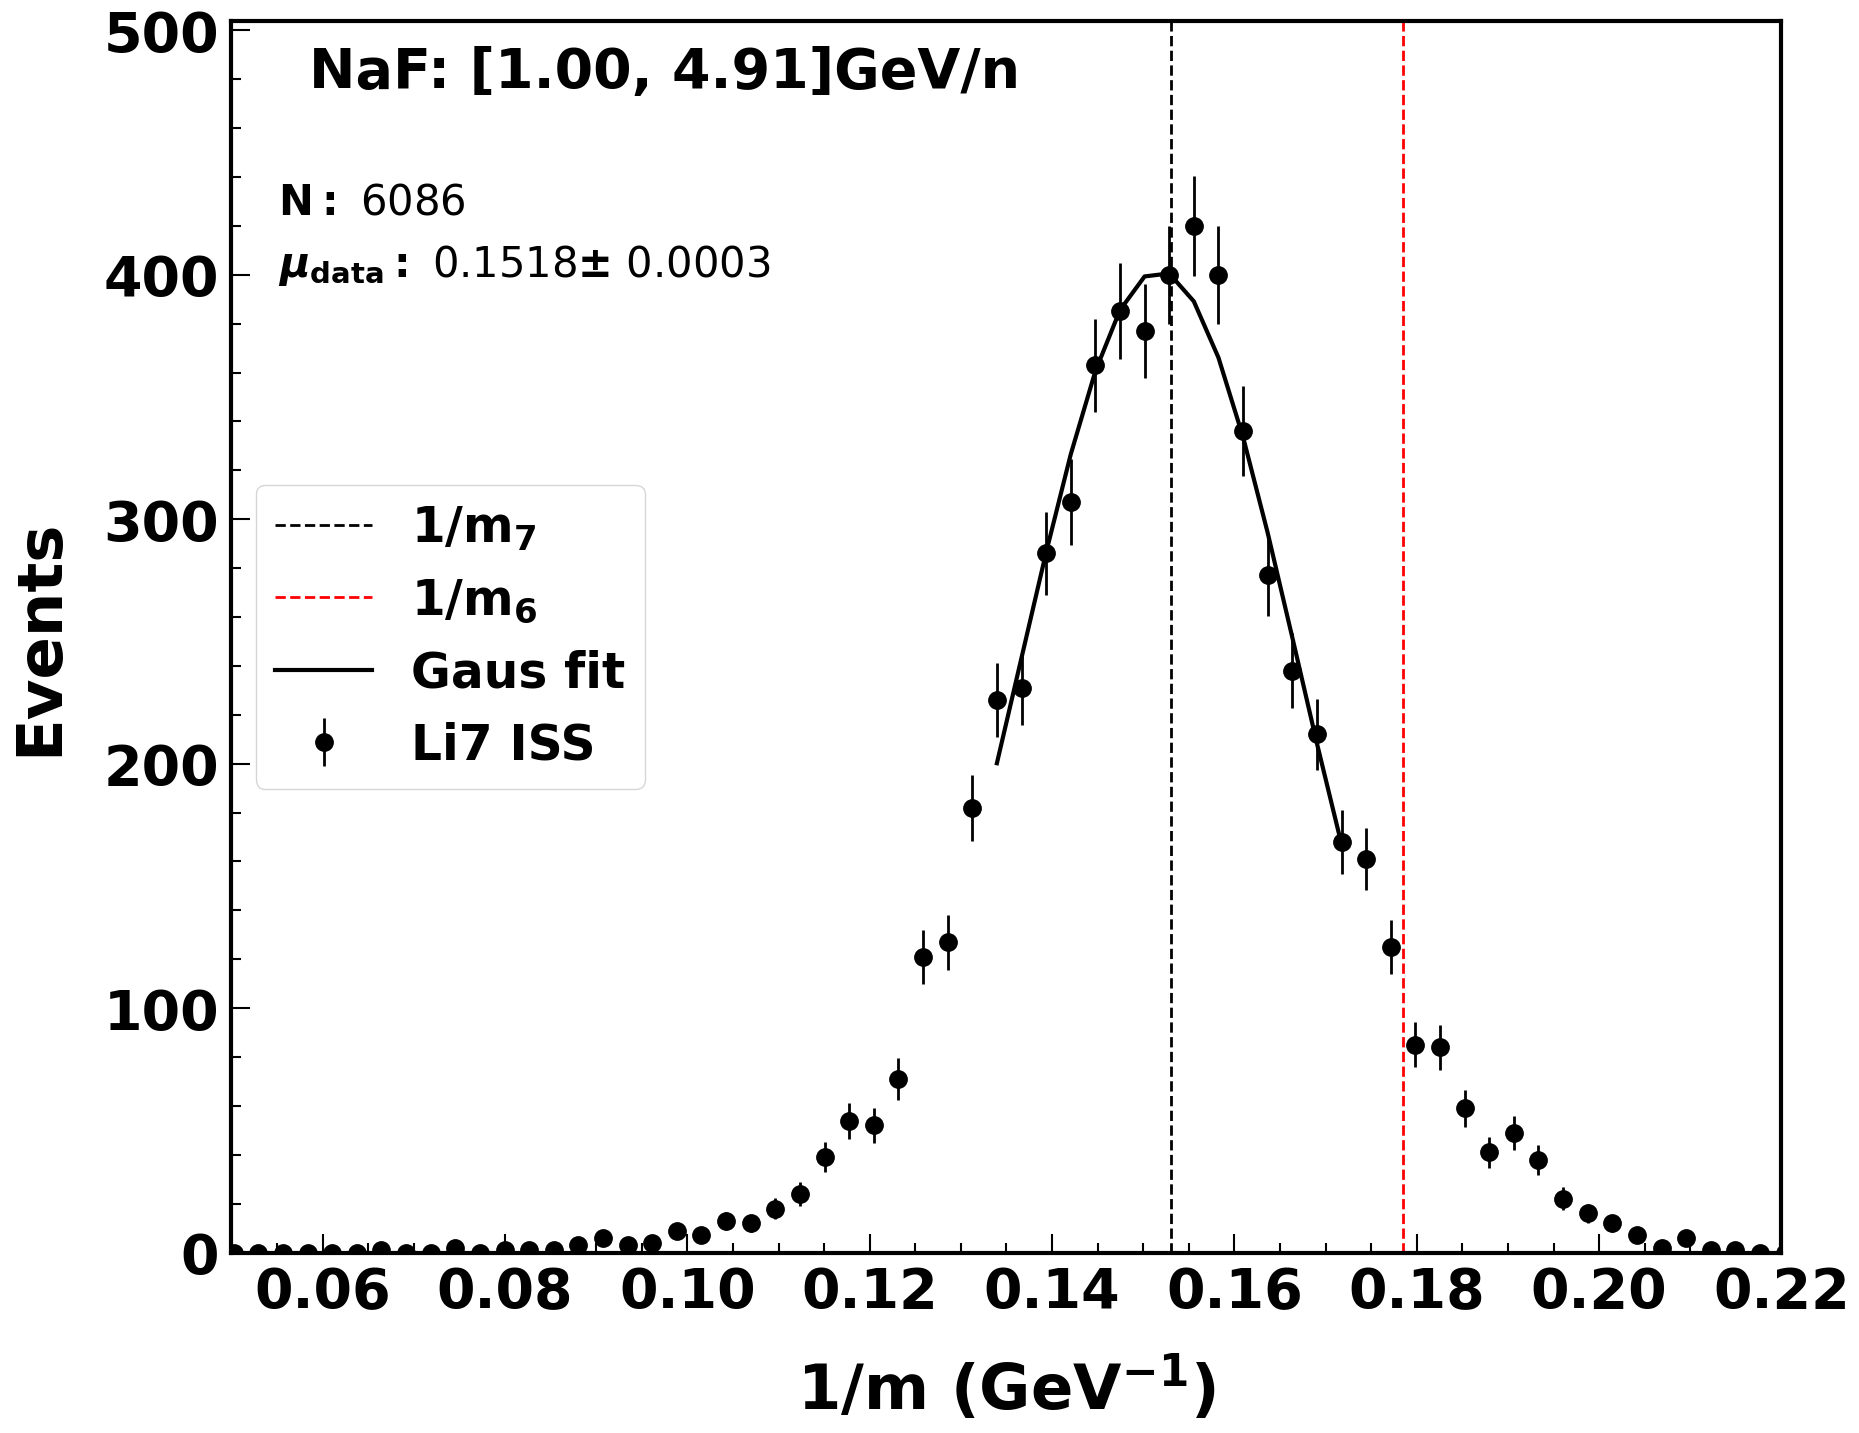

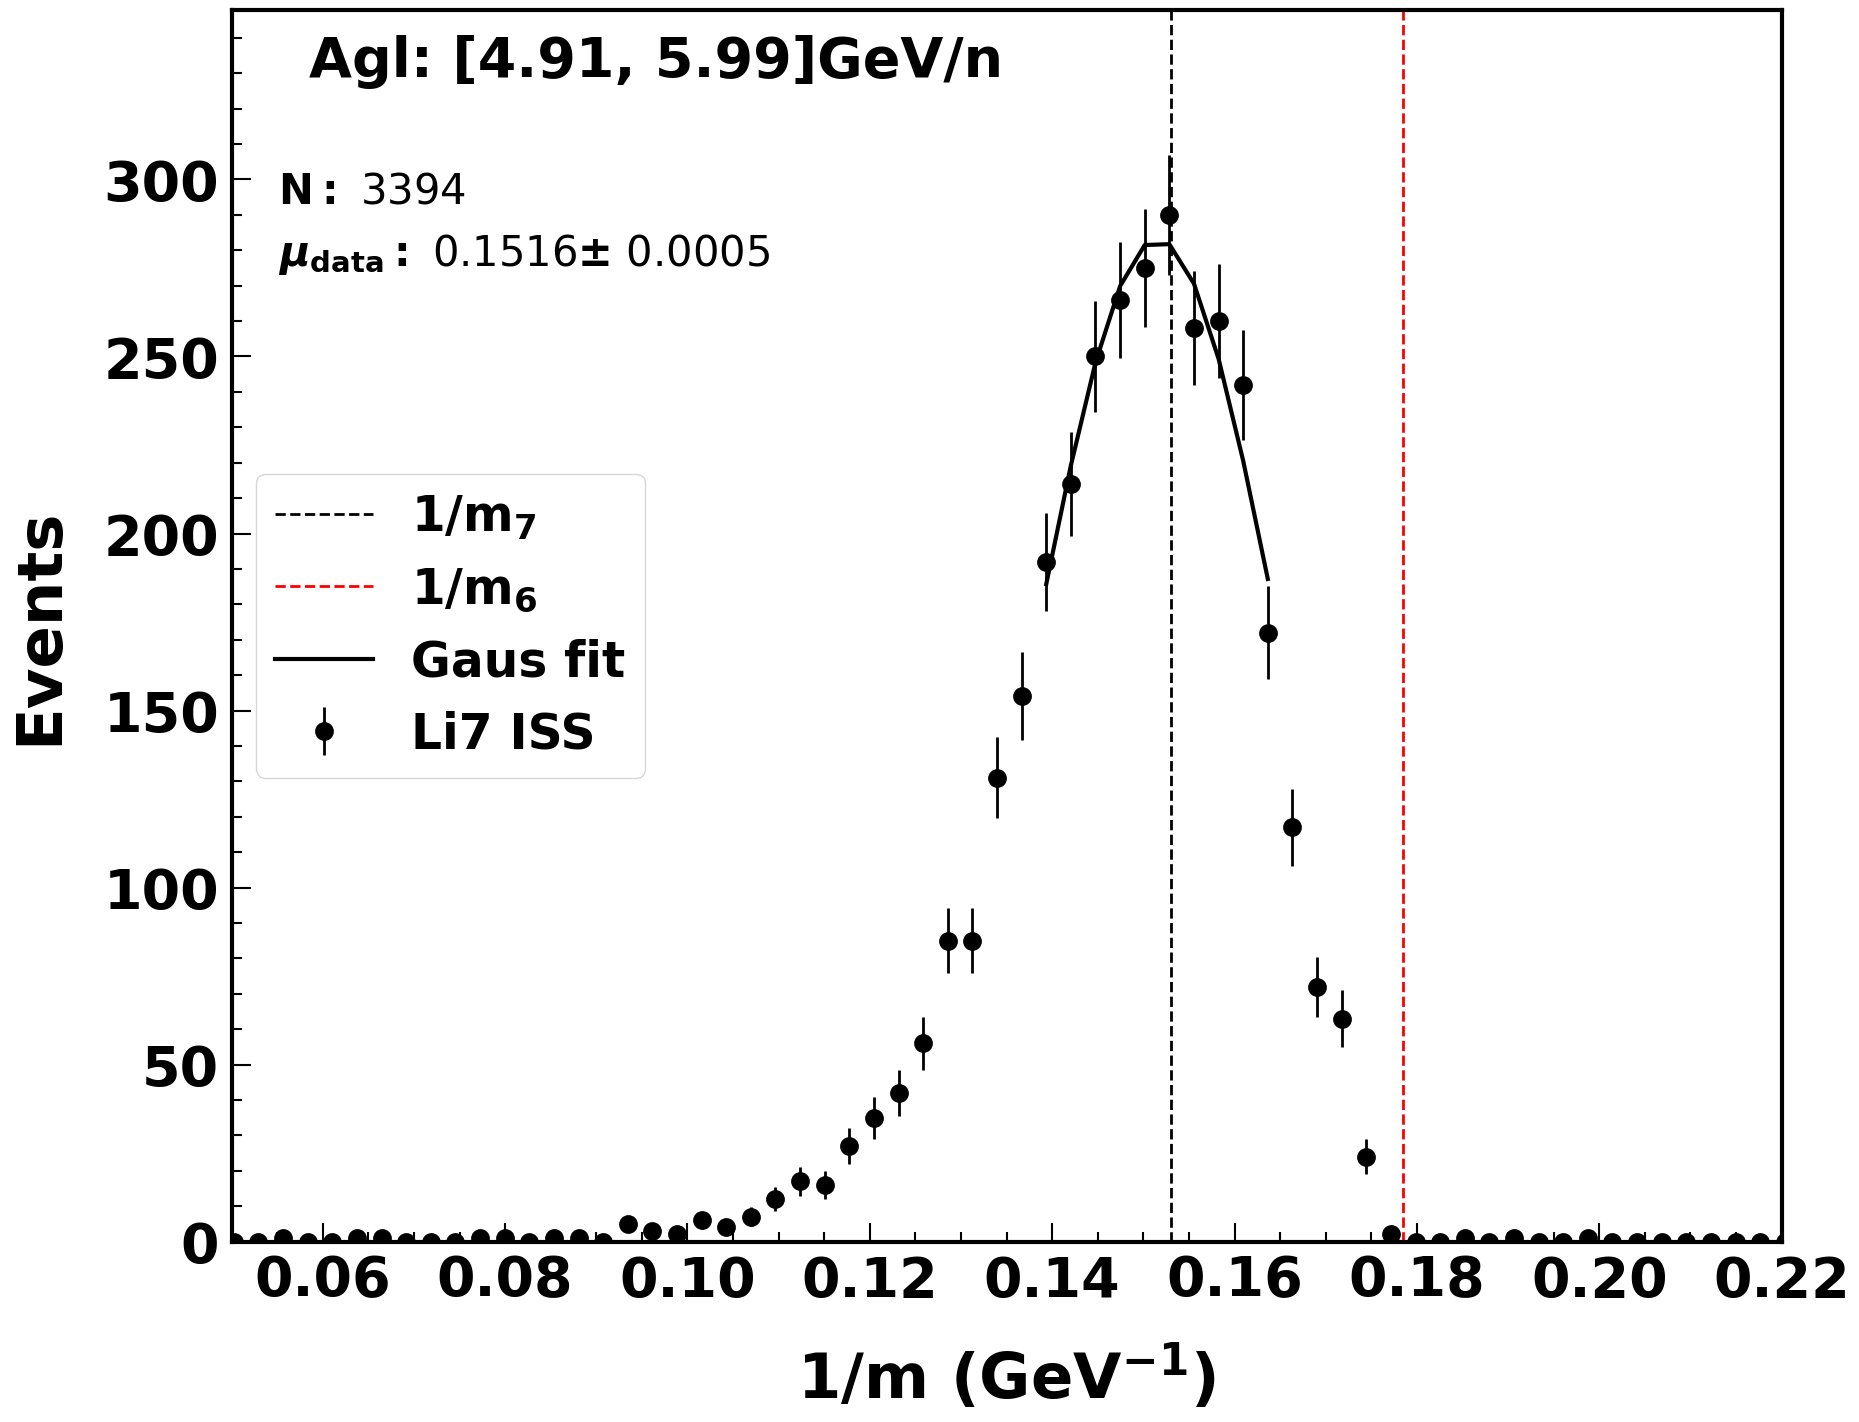

In [83]:
minbin = {'Tof': 1, 'NaF':2, 'Agl':10}
maxbin =  {'Tof':2,  'NaF':3, 'Agl':11}
sigmafactor = {'Tof':2,  'NaF':2, 'Agl':1.8}
guess0 = dict(norm=1, mu=0.14, sigma=0.01)
xrange = {'Tof': [0.135, 0.175], 'NaF': [0.135, 0.175], 'Agl': [0.138, 0.165]}

graph_mean_mc = {}
graph_mean_data = {}
drawiss = True

for dec in ['Tof', 'NaF', 'Agl']:
    energy_binvalues = hist2dmass[dec].binnings[0].bin_centers[minbin[dec]:maxbin[dec]]
    graph_mean_mc[dec] = MGraph(energy_binvalues, np.zeros_like(energy_binvalues), yerrs=np.zeros_like(energy_binvalues))
    graph_mean_data[dec] = MGraph(energy_binvalues, np.zeros_like(energy_binvalues), yerrs=np.zeros_like(energy_binvalues))

    for ip, ibin in enumerate(range(minbin[dec], maxbin[dec])):
        fig, ax1 = plt.subplots(1, 1, figsize=(20, 16))
        hist1dmassbin = hist2dmass[dec].project(ibin)
        print(ibin, hist2dmass[dec].binnings[0].bin_centers[ibin])
        bincenter = hist2dmass[dec].binnings[0].bin_centers[ibin]
        binedges = hist2dmass[dec].binnings[0].edges
        
        
        hist1dmassbin_iss = hist2dmass_iss[dec].project(ibin)
        #print('iss', sum(hist1dmassbin_iss.values))
        if not drawiss:
            ax1.text(0.03, 0.87, f"$\mathrm{{N}}:$ {np.sum(hist1dmassbin.values):.0f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=col['iss'], weight='normal')  
        hist1dmassbin.values = hist1dmassbin.values * sum(hist1dmassbin_iss.values)/sum(hist1dmassbin.values)
        
        set_plot_style(ax1)
        
       
        ax1.text(0.05, 0.98, '{}: [{:.2f}, {:.2f}]GeV/n'.format(dec, binedges[ibin], binedges[ibin+1]),  fontsize=40, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color="black", fontweight="bold")      
        ax1.axvline(x=1/ISOTOPES_MASS['Li7'], linewidth=2,color='black', linestyle='--', label=r'$\mathrm{1/m_{7}}$') 
        ax1.axvline(x=1/ISOTOPES_MASS['Li6'], linewidth=2,color='red', linestyle='--', label=r'$\mathrm{1/m_{6}}$') 
    
        #ax1.fill_betweenx(np.linspace(-1,1.5 * max(hist1dmassbin_iss.values), 100), 0.134, 0.17, color='tab:blue', alpha=0.1)
        #ax1.axvline(x=1/ISOTOPES_MASS['Li6'], linewidth=2,color='grey', linestyle='--', label=r'$\mathrm{m^{nominal}_{6}}$') 
        #savefig_tofile(fig, plotfile, f"hist_datamc_compare_{dec}{iso}_{ibin}_{figName}", show=True)  
        print(plotfile)
        print(f"histmc_{dec}{iso}_{ibin}_Li7")
        xbinrange = hist1dmassbin_iss.binnings[0].get_indices(xrange[dec])
        xedges = hist1dmassbin_iss.binnings[0].edges[xbinrange[0]:xbinrange[1]+1]
        xvalue = hist1dmassbin_iss.binnings[0].bin_centers[xbinrange[0]:xbinrange[1]]
        yvalue = hist1dmassbin_iss.values[xbinrange[0]:xbinrange[1]]
        yvalueserr = np.sqrt(yvalue)
        yvalueserr[yvalueserr==0] = 0.0001
        par_iss, parerr_iss = minuitfit_Chi(xvalue, yvalue, yvalueserr,normalized_gaussian, guess0)
        fit_y_iss = normalized_gaussian(xvalue, *par_iss) 
        
        
        yvalue_mc = hist1dmassbin.values[xbinrange[0]:xbinrange[1]]
        yvalueserr_mc = np.sqrt(yvalue_mc)
        yvalueserr_mc[yvalueserr_mc==0] = 0.0001
        par_mc, parerr_mc = minuitfit_Chi(xvalue, yvalue_mc, yvalueserr_mc ,normalized_gaussian, guess0)
        fit_y_mc = normalized_gaussian(xvalue, *par_mc) 
        print(par_mc)
        print(par_iss)
        print(par_iss['mu']/par_mc['mu'])
        
        #ax1.text(0.03, 0.98, f'Data ', fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax3.transAxes, color=isscolor, weight='normal')  
        #ax1.text(0.03, 0.8, rf"\\mu: {par_iss['mu']:.4f}$\\pm$ {parerr_iss['mu']:.4f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=col['iss'], weight='normal')  
        
        graph_mean_mc[dec].yvalues[ip] = par_mc['mu']
        graph_mean_mc[dec].yerrs[ip] = parerr_mc['mu']
        graph_mean_data[dec].yvalues[ip] = par_iss['mu']
        graph_mean_data[dec].yerrs[ip] = parerr_iss['mu']
        
        if drawiss:
            plot_histogram_1d(ax1, hist1dmassbin_iss, style="iss", color=col['iss'], label=f'{iso} ISS', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2, markersize=25)
            ax1.plot(xvalue, fit_y_iss, '-', linewidth=3, color=col['iss'], label='Gaus fit')
            ax1.text(0.03, 0.87, f"$\mathrm{{N}}:$ {np.sum(hist1dmassbin_iss.values):.0f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=col['iss'], weight='normal')  
            ax1.text(0.03, 0.82, f"$\\mu_{{\mathrm{{data}} }}:$ {par_iss['mu']:.4f}$\\pm$ {parerr_iss['mu']:.4f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=col['iss'], weight='normal')  
        
        else:
            plot_histogram_1d(ax1, hist1dmassbin, style="iss", color=col['mc'], label=f'Li7 MC', scale=None, gamma=None, xlog=False, ylog=False, linewidth=2, markersize=25)
            ax1.plot(xvalue, fit_y_mc, '-', linewidth=3, color=col['mc'], label='Gaus fit')
            ax1.text(0.03, 0.82, f"$\\mu_{{\mathrm{{mc}} }}:$ {par_mc['mu']:.4f}$\\pm$ {parerr_mc['mu']:.4f}", fontsize=30, verticalalignment='top', horizontalalignment='left', transform=ax1.transAxes, color=col['iss'], weight='normal')  
            
        print(plotfile)
        SetAx1Axis(ax1, r'$\mathrm{1/m \ (GeV^{-1})}$', 'Events', 45, xlimrange=[0.05, 0.22], ylimrange=[-0.01, 1.2 * max(hist1dmassbin_iss.values)] , custom_ticks=None, custom_tickslabels=None, gridx=False, gridy=False)
        ax1.legend(fontsize=35, loc='center left')
        print(dec, 'number events:', np.sum(hist1dmassbin.values[10:90]))
        plotfile='/home/manbing/Documents/lithiumanalysis/slides/plots_16May'
        if drawiss:
            savefig_tofile(fig, plotfile, f"histiss_{dec}{iso}_{ibin}_fit_iss", show=True) 
        else:
            savefig_tofile(fig, plotfile, f"histiss_{dec}{iso}_{ibin}_fit_mc", show=True) 
       